In [ ]:
import os
job_cancel_str="scancel " + os.environ['SLURM_JOBID']
os.system(job_cancel_str)

# Imports, Paths, and loading data

In [255]:
%load_ext autoreload
%autoreload 2

In [256]:
import sys, os

sys.path.append(os.path.abspath('../..'))

In [257]:
from hit_finding.constants import *
from hit_finding.metrics import *
from learning_tabular.constants import CHANNELS, FAMILIES, LABEL_FIELD
from learning_tabular.preprocessing import load_plate_csv, list_columns
from reproducibility.percantage_replicates_utils import *

In [258]:
# from os import chdir, scandir, makedirs
import matplotlib.pyplot as plt
# from matplotlib.gridspec import GridSpec
import seaborn as sns


from tqdm.notebook import tqdm
from glob import glob

# from itertools import cycle
# from multiprocessing import Pool, cpu_count

import pandas as pd
import numpy as np
import json
import pickle

In [259]:
num_plates = 5
num_plates = len(files)
num_plates = 406
num_rand = 500
new_ss = True
ss_val ='median'
binary_ss = True

In [260]:
pd.get_option("display.max_rows",100)
'''/home/alonshp/.conda/envs/tf-env/bin/python'''

output_dir = f'/storage/users/g-and-n/reproduce_results_all'
os.makedirs(output_dir, exist_ok=True)


percantage_replicating_filename = f'percentage_replicating_{num_plates}_{num_rand}.csv'
df_null_p_vals_filename = f'df_null_p_vals_{num_plates}_{num_rand}.csv'
null_dist_filename = f'null_distribution_replicates_{num_plates}_{num_rand}.pickle'

if binary_ss:
        percantage_replicating_filename = f'percentage_replicating_binary_{num_plates}_{num_rand}.csv'
        df_null_p_vals_filename = f'df_null_p_vals_binary_{num_plates}_{num_rand}.csv'
        null_dist_filename = f'null_distribution_replicates_binary_{num_plates}_{num_rand}.pickle'


percantage_replicating_path = os.path.join(output_dir, percantage_replicating_filename)
null_dist_filename = f'null_distribution_replicates_{num_plates}_{num_rand}.pickle'
df_null_p_vals_path = os.path.join(output_dir, df_null_p_vals_filename)
null_dist_path = os.path.join(output_dir, null_dist_filename)
null_dist_scores_path = os.path.join(output_dir, 'null_scores')

cols = json.load(open('/storage/users/g-and-n/plates/columns-fs.json', 'r'))
# cols = json.load(open('/storage/users/g-and-n/plates/columns.json', 'r'))

chans = [c for c in cols.keys() if c not in ['GENERAL', 'MIXED']]
chans

del cols['GENERAL']
# del cols['MIXED'] 

cols['ALL'] = sum(cols.values(), [])
num_channels_all = len(cols['ALL'] )


err_fld = f'/storage/users/g-and-n/tabular_models_results/41/ALL/zscores/'
files = [(int(f.name.split('.')[0]), f.name) for f in os.scandir(err_fld) if f.name.endswith('.csv')]

if 'alonshp' in os.path.abspath('../code'):
    userid = 'alonshp'
else:
    userid = 'naorko'

if userid == 'alonshp':
    res_dir = os.path.abspath('../../../assafzar-group/g-and-n/')
    sys.path.append(res_dir)
    res_pth = os.path.join('/sise/assafzar-group/g-and-n/tabular_models_results/30000/results/z_scores/pure')
    plates = os.listdir(os.path.join(res_pth, 'err'))
else:
    sys.path.append(os.path.abspath('../code'))
    res_pth = '../../../tabular_models_results/11/results/z_scores/frac_score'
    t = 4
    # plates = os.listdir(os.path.join(res_pth, str(4)))
    res_path_thresh = os.path.join(res_pth, str(t))
    plates = os.listdir(os.path.join(res_pth, str(t)))

    

### Pre proccess models zscores

In [261]:
zscores = {
    # '4to1':{'path':f'/storage/users/g-and-n/tabular_models_results/41/ALL/zscores'},
    # '2to1':{'path':f'/storage/users/g-and-n/tabular_models_results/21/ALL/zscores'},
    '1to1':{'path':f'/storage/users/g-and-n/tabular_models_results/111/ALL/zscores'},
    'raw':{'path': f'/storage/users/g-and-n/tabular_models_results/30000/results/z_scores/pure/raw'},
    # '5to5':{'path':f'/storage/users/g-and-n/tabular_models_results/55/ALL/zscores'},
}

# get plate numbers
cur_fld = f'/storage/users/g-and-n/tabular_models_results/41/ALL/'
all_plates = glob(os.path.join(cur_fld, 'zscores', '*'))
# plate_nums = [
#     25579, 25580, 25581, 25583,
#     25891, 25892, 25903, 25911,
#     24646, 24647, 24648, 24651,
#     26724, 26730, 26744, 26745,
#     25993, 25994, 25997, 26002,
#     24638, 24639, 24640, 24641,
#     25904, 25912, 25913, 25914,
#     26767, 26768, 26771, 26772,
#     24514, 24515, 24516, 24517,
#     24656, 24657, 24661, 24663,
#     26681, 26682, 26683, 26684,
#     26666, 26668, 26669, 26786,
#     26702, 26703, 26739, 26748,
#     25689, 25690, 25692, 25724,
#     24652, 24653, 24654, 24655,
#     24756, 24758, 24759, 24773,
#     26640, 26641, 26642, 26643,
#     24684, 24685, 24687, 24688,
#     26685, 26688, 26695, 26705,
#     25925, 25929, 25931, 25935
# ]
# plate_nums = [f'{p}.csv' for p in plate_nums]
plate_nums = [os.path.split(plate)[-1] for plate in all_plates]


# load zscores
for model in zscores.keys():
    plates =  [os.path.join(zscores[model]['path'], plate) for plate in plate_nums]
    zscores[model]['all'] = pd.concat([pd.read_csv(pth, index_col=[0, 1, 2, 3]) for pth in plates])
    if binary_ss:
        zscores[model]['all'][(zscores[model]['all']<2) & (zscores[model]['all']>-2)]=0
        zscores[model]['all'][(zscores[model]['all']>=2) | (zscores[model]['all']<=-2)]=1
        

In [262]:
zscores[model]['all'].head()


Cells_AreaShape_Area  \
Plate Metadata_ASSAY_WELL_ROLE Metadata_broad_sample Image_Metadata_Well                         
24277 mock                     DMSO                  a13                                   1.0   
                                                     a14                                   0.0   
                                                     b13                                   0.0   
                                                     b14                                   0.0   
                                                     c11                                   0.0   

                                                                          Cells_AreaShape_Center_X  \
Plate Metadata_ASSAY_WELL_ROLE Metadata_broad_sample Image_Metadata_Well                             
24277 mock                     DMSO                  a13                                       0.0   
                                                     a14                                       0.0   
                                                     b13                                       0.0   
                                                     b14                                       0.0   
                                                     c11                                       0.0   

                                                                          Cells_AreaShape_Center_Y  \
Plate Metadata_ASSAY_WELL_ROLE Metadata_broad_sample Image_Metadata_Well                             
24277 mock                     DMSO                  a13                                       0.0   
                                                     a14                                       0.0   
                                                     b13                                       0.0   
                                                     b14                                       0.0   
                                                     c11                                       0.0   

                                                                          Cells_AreaShape_Compactness  \
Plate Metadata_ASSAY_WELL_ROLE Metadata_broad_sample Image_Metadata_Well                                
24277 mock                     DMSO                  a13                                          0.0   
                                                     a14                                          0.0   
                                                     b13                                          0.0   
                                                     b14                                          0.0   
                                                     c11                                          0.0   

                                                                          Cells_AreaShape_Eccentricity  \
Plate Metadata_ASSAY_WELL_ROLE Metadata_broad_sample Image_Metadata_Well                                 
24277 mock                     DMSO                  a13                                           0.0   
                                                     a14                                           0.0   
                                                     b13                                           0.0   
                                                     b14                                           0.0   
                                                     c11                                           0.0   

                                                                          Cells_AreaShape_EulerNumber  \
Plate Metadata_ASSAY_WELL_ROLE Metadata_broad_sample Image_Metadata_Well                                
24277 mock                     DMSO                  a13                                          0.0   
                                                     a14                                          0.0   
                                                     b13  

In [263]:
### Drop columns that are not in other results

# find joint columns
joint_cols = []
for model in zscores.keys():
    model_cols = zscores[model]['all'].columns
    if len(joint_cols)==0:
        joint_cols = model_cols
        print(len(joint_cols))
    else:
        joint_cols = np.intersect1d(joint_cols,model_cols)
        print(len(joint_cols))
        
# drop non-joint columns
for model in zscores.keys():
    zscores[model]['all'].drop(columns=[c for c in zscores[model]['all'].columns if c not in joint_cols], inplace=True)
    print(zscores[model]['all'].shape)

169
169
(146599, 169)
(153015, 169)


In [264]:
# zscores['raw']['all'].isna().sum().sum()
zscores['1to1']['all'].isna().sum().sum()

4012

In [265]:
for model in zscores.keys():
    zscores[model]['all'].fillna(0,inplace=True)
    print(zscores[model]['all'].shape)

(146599, 169)
(153015, 169)


In [266]:
n, feature_n = zscores['1to1']['all'].shape

In [267]:
feature_n

169

In [268]:
# divide control cells and treated cells
for model in zscores.keys():

    zscores[model]['trt'] =zscores[model]['all'].query('Metadata_ASSAY_WELL_ROLE == "treated"')
    zscores[model]['ctl'] =zscores[model]['all'].query('Metadata_ASSAY_WELL_ROLE == "mock"')

In [269]:
for model in zscores.keys():
    print(zscores[model]['trt'].index.get_level_values(2).value_counts().value_counts())

4    24933
3     2759
8     1913
2      401
7      322
1      106
6        4
Name: Metadata_broad_sample, dtype: int64
4    24933
3     2759
8     1913
2      401
7      322
1      106
6        4
Name: Metadata_broad_sample, dtype: int64


In [270]:
zscores['1to1']['all'].index.get_level_values(2)

Index(['DMSO', 'DMSO', 'DMSO', 'DMSO', 'DMSO', 'DMSO', 'DMSO', 'DMSO', 'DMSO',
       'DMSO',
       ...
       'BRD-K96218183-001-01-5', 'BRD-K96743424-001-01-1',
       'BRD-K96845170-001-01-0', 'BRD-K98028441-001-01-4',
       'BRD-K98108103-001-01-3', 'BRD-K98110717-001-01-7',
       'BRD-K98427581-001-01-8', 'BRD-K98538413-001-01-6',
       'BRD-K98758861-001-01-7', 'BRD-K99216703-001-01-7'],
      dtype='object', name='Metadata_broad_sample', length=146599)

In [279]:
def get_median_score(cpds_list, df):
    """
    This function calculates the median score for each compound based on its replicates
    """

    cpds_median_score = {}
    for cpd in cpds_list:
        cpd_replicates = df[df.index.isin([cpd], 2)].copy()
        cor_mat = cpd_replicates.astype('float64').T.corr(method='pearson').values
        # cor_mat = np.nan_to_num(cor_mat)
        if len(cor_mat) == 1:
            median_val = 1
        else:
            median_val = np.median(cor_mat[np.triu_indices(len(cor_mat), k=1)])

        cpds_median_score[cpd] = median_val

    return cpds_median_score

In [280]:
# test_raw = zscores['raw']['all'].loc[zscores['raw']['all'].index.get_level_values(2)=='BRD-K97185232-001-01-6',:]
# test_1to1 = zscores['1to1']['all'].loc[zscores['1to1']['all'].index.get_level_values(2)=='BRD-K97185232-001-01-6',:]

test_raw = zscores['raw']['all'].loc[zscores['raw']['all'].index.get_level_values(2)=='BRD-A01621189-001-06-9',:]
test_1to1 = zscores['1to1']['all'].loc[zscores['1to1']['all'].index.get_level_values(2)=='BRD-A01621189-001-06-9',:]

replicates_df, cpds = get_duplicate_replicates(test_1to1)
replicates_df.sum().sum()
cpds_score_df = get_median_score(cpds, replicates_df)
# cor_mat = replicates_df.astype('float64').T.corr(method='pearson').values
# cor_mat = np.nan_to_num(cor_mat)
# cor_mat
cpds_score_df
# test_1to1.isna().sum().sum()

{'BRD-A01621189-001-06-9': nan}

In [244]:
zscores['1to1']['all'].head()

Cells_Granularity_1_AGP  \
Plate Metadata_ASSAY_WELL_ROLE Metadata_broad_sample Image_Metadata_Well                            
24277 mock                     DMSO                  a14                                      0.0   
                                                     b13                                      0.0   
                                                     b14                                      0.0   
                                                     c11                                      0.0   
                                                     c12                                      0.0   

                                                                          Cells_Intensity_IntegratedIntensityEdge_AGP  \
Plate Metadata_ASSAY_WELL_ROLE Metadata_broad_sample Image_Metadata_Well                                                
24277 mock                     DMSO                  a14                                                          0.0   
                                                     b13                                                          0.0   
                                                     b14                                                          0.0   
                                                     c11                                                          0.0   
                                                     c12                                                          0.0   

                                                                          Cells_Intensity_IntegratedIntensity_AGP  \
Plate Metadata_ASSAY_WELL_ROLE Metadata_broad_sample Image_Metadata_Well                                            
24277 mock                     DMSO                  a14                                                      0.0   
                                                     b13                                                      0.0   
                                                     b14                                                      0.0   
                                                     c11                                                      0.0   
                                                     c12                                                      0.0   

                                                                          Cells_Intensity_MADIntensity_AGP  \
Plate Metadata_ASSAY_WELL_ROLE Metadata_broad_sample Image_Metadata_Well                                     
24277 mock                     DMSO                  a14                                               1.0   
                                                     b13                                               0.0   
                                                     b14                                               0.0   
                                                     c11                                               0.0   
                                                     c12                                               0.0   

                                                                          Cells_Intensity_MassDisplacement_AGP  \
Plate Metadata_ASSAY_WELL_ROLE Metadata_broad_sample Image_Metadata_Well                                         
24277 mock                     DMSO                  a14                                                   0.0   
                                                     b13                                                   0.0   
                                                     b14                                                   0.0   
                                                     c11                                                   0.0   
                                                     c12                                                   0.0   

                                                                          Cells_Intensity_MaxIntensityEdge_AGP  \
Plate Metadata

# Produce null disribution

## Compute median scores

In [282]:
cpds_med_score = {f'{m}_{t}': get_replicates_score(zscores[m][t])
                  for m in zscores.keys()
                  for t in ['trt', 'ctl']
                 }

cpds_score_df_trt = pd.DataFrame({k[:-4]: v for k, v in cpds_med_score.items() if 'trt' in k})
cpds_score_df_ctl = pd.DataFrame({k[:-4]: v for k, v in cpds_med_score.items() if 'ctl' in k})

display(cpds_score_df_trt)

1to1       raw
BRD-K17705806-003-01-0 -0.003197  0.025916
BRD-A01621189-001-06-9  0.000000  0.000000
BRD-A02763478-001-06-8 -0.014526  0.000000
BRD-A04287036-001-04-6 -0.042920 -0.024387
BRD-A04544673-001-05-5 -0.018492 -0.003921
...                          ...       ...
BRD-K97029281-001-02-4 -0.005186  0.000000
BRD-K97408390-001-01-0 -0.023497  0.000000
BRD-K97614198-001-01-7 -0.027543  0.000000
BRD-K98092496-001-01-4  0.050765  0.000000
BRD-K98383296-001-02-7 -0.025098 -0.015255

[24933 rows x 2 columns]

In [284]:
cpds_score_df_trt.isna().sum()

1to1    0
raw     0
dtype: int64

## Create null distribution

In [285]:
os.path.exists(null_dist_path)

True

In [286]:
if not os.path.exists(null_dist_path):

    replicates_df, cpds = get_duplicate_replicates(zscores['1to1']['trt'],min_num_reps=4)
    null_distribution_replicates = get_null_distribution_replicates(replicates_df, cpds, rand_num=num_rand,num_reps_in_rand=4)

    duplicate_replicates = assert_null_distribution(null_distribution_replicates)
    assert len(duplicate_replicates)==0, 'there are duplicate replicates in null distribution' ## no replicates


    # null_distribution_replicates.to_csv(f'null_distribution_replicates_{num_plates}.csv')
    with open(null_dist_path, 'wb') as handle:
        pickle.dump(null_distribution_replicates, handle, protocol=pickle.HIGHEST_PROTOCOL)

else:
    with open(null_dist_path, 'rb') as f:
    # Load the pickle file 
        null_distribution_replicates = pickle.load(f)
    # null_distribution_replicates = pickle.load(null_dist_filename)
    
# replicates_df.head()
len(null_distribution_replicates)

Exception ignored in: <function tqdm.__del__ at 0x7f8f54ae7ee0>
Traceback (most recent call last):
  File "/home/alonshp/.conda/envs/tf-env/lib/python3.8/site-packages/tqdm/std.py", line 1162, in __del__
    self.close()
  File "/home/alonshp/.conda/envs/tf-env/lib/python3.8/site-packages/tqdm/notebook.py", line 287, in close
    self.disp(bar_style='danger', check_delay=False)
AttributeError: 'tqdm_notebook' object has no attribute 'disp'


24933

In [287]:
null_distribution_replicates['BRD-A00037023-001-05-1'][0]

[(25490, 'treated', 'BRD-K33728616-001-05-7', 'l17'),
 (26126, 'treated', 'BRD-K48276916-001-05-7', 'g09'),
 (25593, 'treated', 'BRD-K02065805-001-05-2', 'f05'),
 (25892, 'treated', 'BRD-K73400194-001-01-3', 'n01')]

In [288]:
cpds = list(null_distribution_replicates.keys())
cpds.sort()
len(cpds)

24933

In [289]:
with open('/sise/assafzar-group/g-and-n/reproduce_results_all/null_scores/1to1/0.pickle', 'rb') as f:
    # Load the pickle file
        x = pickle.load(f)

In [290]:
glob(os.path.join(null_dist_scores_path, 'raw', '*')).__len__()

998

In [291]:
df = pd.DataFrame(columns=zscores.keys())
df.loc['a'] = (1,2)

In [292]:
df.loc['b','raw'] = 4
df

1to1  raw
a   1.0  2.0
b   NaN  4.0

In [296]:
from tqdm import tqdm
cpds_score_df_trt = pd.DataFrame(columns=zscores.keys())
null_distribution_medians = {}
for method in zscores.keys():
    null_distribution_medians[method] = {}
    scores_files = glob(os.path.join(null_dist_scores_path, method, '*'))
    scores_files.sort()
    for scores_file in tqdm(scores_files):
        with open(scores_file, 'rb') as f:
        # Load the pickle file
            d = pickle.load(f)
        for k, (med_score, null_med_scores) in d.items():
            null_distribution_medians[method][k] = null_med_scores
            cpds_score_df_trt.loc[k, method] = med_score


 32%|███▏      | 321/998 [00:23<01:01, 11.01it/s]Exception ignored in: <function tqdm.__del__ at 0x7f8f54ae7ee0>
Traceback (most recent call last):
  File "/home/alonshp/.conda/envs/tf-env/lib/python3.8/site-packages/tqdm/std.py", line 1162, in __del__
    self.close()
  File "/home/alonshp/.conda/envs/tf-env/lib/python3.8/site-packages/tqdm/notebook.py", line 287, in close
    self.disp(bar_style='danger', check_delay=False)
AttributeError: 'tqdm_notebook' object has no attribute 'disp'

100%|██████████| 998/998 [00:38<00:00, 26.05it/s]


## Calculate Median Scores P-values

In [297]:
if not os.path.exists(percantage_replicating_path):
    # null_distribution_medians = {}
    # for model in zscores.keys():
    #     null_distribution_medians[model] = get_null_dist_median_scores(null_distribution_replicates, zscores[model]['trt'])
    # null_distribution_medians['raw1to1'] = get_null_dist_median_scores(null_distribution_replicates, cpd_raw1to1_trt)

    df_null_p_vals = pd.DataFrame([])
    methods=zscores.keys()
    for method in zscores.keys():
        # null_distribution_medians = get_null_dist_median_scores(null_distribution_replicates, cpds_score_df_trt,method=method)
        null_p_vals = get_moa_p_vals(null_distribution_medians[method], cpds_score_df_trt, method=method)
        method_df_null_p_vals = pd.DataFrame.from_dict(null_p_vals,orient='index',columns=[method])
        if len(df_null_p_vals)>0:
            df_null_p_vals = df_null_p_vals.join(method_df_null_p_vals)
        else:
            df_null_p_vals = method_df_null_p_vals.copy()

        # cpds_score_df_trt = cpds_score_df_trt.join(df_null_p_vals)

    display(df_null_p_vals)

    medians = cpds_score_df_trt[methods].melt(var_name=["method"],value_name='median_score',ignore_index=False).reset_index()
    p_vals = df_null_p_vals[methods].melt(var_name=["method"],value_name='p_val',ignore_index=False).reset_index()
    cpds_score_df_trt.to_csv(f'cpds_score_df_trt_{num_plates}.csv')
    df_null_p_vals.to_csv(df_null_p_vals_path)
    # a = pd.merge(medians,p_vals, left_on=['index','median_score'], right_on=['index','p_val'])
    percantage_replicating_df = pd.merge(medians,p_vals, on=['index','method'])
    percantage_replicating_df.to_csv(percantage_replicating_path) #, index=False, sep="\t")
    
else:
    
    percantage_replicating_df = pd.read_csv(percantage_replicating_path)
    df_null_p_vals = pd.read_csv(df_null_p_vals_path)


1to1    raw
BRD-A00037023-001-05-1  0.004  0.004
BRD-A00051892-001-05-0  0.014  0.004
BRD-A00214921-001-04-2  0.066  0.326
BRD-A00250346-001-05-0  0.048  0.004
BRD-A00430899-001-05-9  0.004  0.014
...                       ...    ...
BRD-M97057852-001-01-4  0.298  0.052
BRD-M97109212-001-01-8  0.002  0.096
BRD-M97925630-001-01-1  0.032  0.014
BRD-M98484762-001-01-8  0.046  0.132
BRD-U62737497-000-01-5  0.000  0.044

[24933 rows x 2 columns]

In [302]:
percantage_replicating_df.shape

(49866, 4)

In [304]:
df_null_p_vals_path

'/storage/users/g-and-n/reproduce_results_all/df_null_p_vals_binary_406_500.csv'

# Load results (PR and SS)
based on https://github.com/broadinstitute/lincs-profiling-complementarity/blob/master/1.Data-exploration/Profiles_level4/cell_painting/9.cellpainting-percent-replicating-subsampled-and-nonspherized.ipynb



In [305]:
import re
import os
import pathlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pickle
sns.set_style("darkgrid")
sns.set_context("talk")

In [306]:
# load reproducibility results
percantage_replicating_df = pd.read_csv(percantage_replicating_path)
percantage_replicating_df.method.value_counts()

# load p_vals
df_null_p_vals= pd.read_csv(df_null_p_vals_path)
df_null_p_vals.rename( columns={'Unnamed: 0':'Metadata_broad_sample'}, inplace=True )
df_null_p_vals.head()

Metadata_broad_sample   1to1    raw
0  BRD-A00037023-001-05-1  0.004  0.004
1  BRD-A00051892-001-05-0  0.014  0.004
2  BRD-A00214921-001-04-2  0.066  0.326
3  BRD-A00250346-001-05-0  0.048  0.004
4  BRD-A00430899-001-05-9  0.004  0.014

In [307]:
percantage_replicating_df.head()

Unnamed: 0                   index method  median_score  p_val
0           0  BRD-A00037023-001-05-1   1to1      0.275282  0.004
1           1  BRD-A00051892-001-05-0   1to1      0.202930  0.014
2           2  BRD-A00214921-001-04-2   1to1      0.139107  0.066
3           3  BRD-A00250346-001-05-0   1to1      0.146440  0.048
4           4  BRD-A00430899-001-05-9   1to1      0.277543  0.004

In [308]:
to_win = False

mcn_sep =  '/'
def convert_path_to_machine(path):
    spl = path.split(mcn_sep)
    if to_win:
        return os.path.join('R:\\', *spl[spl.index('g-and-n'):])
    else:
        return os.path.join('/sise/assafzar-group/', *spl[spl.index('g-and-n'):])


In [309]:
ss_scores = {}

# mtd_names = {
#     41: '4to1',
#     21: '2to1',
#     11: '1to1',
#     1: 'baseline',
#     111: '1to1-fs',
#     0: 'baseline-fs',
#     55: '5to5',
#     5: 'baseline-all-fs',
# }

mtd_names = {
    # 41: '4to1',
    # 21: '2to1',
    # 11: '1to1',
    # 1: 'baseline',
    111: '1to1',
    0: 'raw',
    # 55: '5to5',
    # 5: 'baseline-all-fs',
}
if new_ss: 
    if ss_val =='mean':
        filename ='ss-new-scores-mean'
    else:
        filename ='ss-new-scores-median'
else:
    filename ='ss-scores'
ss_scores = {}
methods = []
for exp_id in [111,0]:#[41, 21, 11]:
    method = mtd_names[exp_id]
    methods.append(method)
    exp_fld = f'/sise/assafzar-group/g-and-n/tabular_models_results/{exp_id}'
    channels_pths = convert_path_to_machine(os.path.join(exp_fld, 'channel '))
    channels = ['AGP', 'DNA', 'ER', 'Mito', 'RNA']
    channels_pths = [os.path.join(exp_fld, 'ALL')] + [channels_pths + c for c in channels]
    channels = ['ALL'] + channels
    res_pths = [os.path.join(chan_pth, f'{filename}.csv') for chan_pth in channels_pths]
    ss_scores[method] = pd.concat([pd.read_csv(pth, index_col=[0]).add_prefix(f'{c}_') for c, pth in zip(channels, res_pths)], axis=1)
    
    
# for exp_id in [0]:#[41, 21, 11]:
#     method = mtd_names[exp_id]
#     methods.append(method)
#     exp_fld = f'/sise/assafzar-group/g-and-n/tabular_models_results/{exp_id}'
#     exp_fld = convert_path_to_machine(exp_fld)
#     channels = ['ALL', 'AGP', 'DNA', 'ER', 'Mito', 'RNA']
#     res_pths = [os.path.join(exp_fld, f'{chan}-{filename}.csv') for chan in channels]
#     ss_scores[method] = pd.concat([pd.read_csv(pth, index_col=[0]).add_prefix(f'{c}_') for c, pth in zip(channels, res_pths)], axis=1)


In [310]:
for method in methods:
    # ss_scores[model]['ss']= ss_scores[model]['ss'].add_prefix('ALL_')
    ss_scores[method]= ss_scores[method].add_suffix(f'_{method}')
# ss_scores['2to1']['ss'] = ss_scores['2to1']['ss'].add_prefix('ALL_')
# ss_scores['1to1']['ss'] = ss_scores['1to1']['ss'].add_prefix('ALL_')

# merge map and raw
if len(ss_scores)==2:
    # all_ss = pd.merge(ss_scores['1to1'], ss_scores['raw'],left_index=True, right_index=True, suffixes=('1to1', 'raw'))
    all_ss = pd.merge(ss_scores['1to1'], ss_scores['raw']/feature_n,left_index=True, right_index=True, suffixes=('1to1', 'raw'))
else:
    pass
# all_ss = pd.merge(ss_scores['4to1']['ss'], ss_scores['2to1']['ss'],left_index=True, right_index=True, suffixes=('_4to1','_2to1'))
# all_ss.columns
all_ss.columns

# keep only 'All' results
all_ss = all_ss.filter(regex='ALL_')
all_ss.columns

Index(['ALL_Unnamed: 1_1to1', 'ALL_Rep_Cnt_1to1', 'ALL_SS_2_1to1',
       'ALL_SS_3_1to1', 'ALL_SS_4_1to1', 'ALL_SS_5_1to1', 'ALL_SS_6_1to1',
       'ALL_SS_7_1to1', 'ALL_SS_8_1to1', 'ALL_SS_9_1to1', 'ALL_SS_10_1to1',
       'ALL_SS_11_1to1', 'ALL_SS_12_1to1', 'ALL_SS_13_1to1', 'ALL_SS_14_1to1',
       'ALL_SS_15_1to1', 'ALL_SS_16_1to1', 'ALL_SS_17_1to1', 'ALL_SS_18_1to1',
       'ALL_SS_19_1to1', 'ALL_SS_20_1to1', 'ALL_Unnamed: 1_raw',
       'ALL_Rep_Cnt_raw', 'ALL_SS_2_raw', 'ALL_SS_3_raw', 'ALL_SS_4_raw',
       'ALL_SS_5_raw', 'ALL_SS_6_raw', 'ALL_SS_7_raw', 'ALL_SS_8_raw',
       'ALL_SS_9_raw', 'ALL_SS_10_raw', 'ALL_SS_11_raw', 'ALL_SS_12_raw',
       'ALL_SS_13_raw', 'ALL_SS_14_raw', 'ALL_SS_15_raw', 'ALL_SS_16_raw',
       'ALL_SS_17_raw', 'ALL_SS_18_raw', 'ALL_SS_19_raw', 'ALL_SS_20_raw'],
      dtype='object')

In [311]:
# # merge both with raw1to1
# ss_scores['1to1']['ss']=ss_scores['1to1']['ss'].add_suffix('_1to1')
# all_ss = pd.merge(all_ss,ss_scores['1to1']['ss'],left_index=True, right_index=True)
# all_ss.columns

# # merge both with raw1to1
# ss_scores['raw']['ss']=ss_scores['raw']['ss'].add_suffix('_raw')
# all_ss = pd.merge(all_ss,ss_scores['raw']['ss'],left_index=True, right_index=True)
all_ss.head()

ALL_Unnamed: 1_1to1  ALL_Rep_Cnt_1to1  ALL_SS_2_1to1  \
Metadata_broad_sample                                                          
BRD-A00037023-001-05-1                    0                 4       0.011834   
BRD-A00051892-001-05-0                    0                 4       0.007396   
BRD-A00100033-001-04-8                    0                 8       0.001479   
BRD-A00214921-001-04-2                    0                 4       0.001479   
BRD-A00250346-001-05-0                    0                 4       0.016272   

                        ALL_SS_3_1to1  ALL_SS_4_1to1  ALL_SS_5_1to1  \
Metadata_broad_sample                                                 
BRD-A00037023-001-05-1       0.004438       0.000000            0.0   
BRD-A00051892-001-05-0       0.001479       0.000000            0.0   
BRD-A00100033-001-04-8       0.000740       0.000000            0.0   
BRD-A00214921-001-04-2       0.000000       0.000000            0.0   
BRD-A00250346-001-05-0       0.004438       0.001479            0.0   

                        ALL_SS_6_1to1  ALL_SS_7_1to1  ALL_SS_8_1to1  \
Metadata_broad_sample                                                 
BRD-A00037023-001-05-1            0.0            0.0            0.0   
BRD-A00051892-001-05-0            0.0            0.0            0.0   
BRD-A00100033-001-04-8            0.0            0.0            0.0   
BRD-A00214921-001-04-2            0.0            0.0            0.0   
BRD-A00250346-001-05-0            0.0            0.0            0.0   

                        ALL_SS_9_1to1  ...  ALL_SS_11_raw  ALL_SS_12_raw  \
Metadata_broad_sample                  ...                                 
BRD-A00037023-001-05-1            0.0  ...            0.0            0.0   
BRD-A00051892-001-05-0            0.0  ...            0.0            0.0   
BRD-A00100033-001-04-8            0.0  ...            0.0            0.0   
BRD-A00214921-001-04-2            0.0  ...            0.0            0.0   
BRD-A00250346-001-05-0            0.0  ...            0.0            0.0   

                        ALL_SS_13_raw  ALL_SS_14_raw  ALL_SS_15_raw  \
Metadata_broad_sample                                                 
BRD-A00037023-001-05-1            0.0            0.0            0.0   
BRD-A00051892-001-05-0            0.0            0.0            0.0   
BRD-A00100033-001-04-8            0.0            0.0            0.0   
BRD-A00214921-001-04-2            0.0            0.0            0.0   
BRD-A00250346-001-05-0            0.0            0.0            0.0   

                        ALL_SS_16_raw  ALL_SS_17_raw  ALL_SS_18_raw  \
Metadata_broad_sample                                                 
BRD-A00037023-001-05-1            0.0            0.0            0.0   
BRD-A00051892-001-05-0            0.0            0.0            0.0   
BRD-A00100033-001-04-8            0.0            0.0            0.0   
BRD-A00214921-001-04-2            0.0            0.0            0.0   
BRD-A00250346-001-05-0            0.0            0.0            0.0   

                        ALL_SS_19_raw  ALL_SS_20_raw  
Metadata_broad_sample                                 
BRD-A00037023-001-05-1            0.0            0.0  
BRD-A00051892-001-05-0            0.0            0.0  
BRD-A00100033-001-04-8            0.0            0.0  
BRD-A00214921-001-04-2            0.0            0.0  
BRD-A00250346-001-05-0            0.0            0.0  

[5 rows x 42 columns]

In [312]:
# all_ss.columns
ts = [2,4,6,8,10,12,14,16,18,20]
ss_cols = []
for t in ts:
    t_cols = all_ss.filter(like=f'SS_{t}_').columns
    ss_cols+=list(t_cols)
    
all_ss_t = all_ss[ss_cols]
all_ss_t.head()
all_ss_t.columns

# keep only 'All' results
only_all_ss_t = all_ss_t.filter(regex='ALL_')
all_ss_t.columns

Index(['ALL_SS_2_1to1', 'ALL_SS_2_raw', 'ALL_SS_4_1to1', 'ALL_SS_4_raw',
       'ALL_SS_6_1to1', 'ALL_SS_6_raw', 'ALL_SS_8_1to1', 'ALL_SS_8_raw',
       'ALL_SS_10_1to1', 'ALL_SS_10_raw', 'ALL_SS_12_1to1', 'ALL_SS_12_raw',
       'ALL_SS_14_1to1', 'ALL_SS_14_raw', 'ALL_SS_16_1to1', 'ALL_SS_16_raw',
       'ALL_SS_18_1to1', 'ALL_SS_18_raw', 'ALL_SS_20_1to1', 'ALL_SS_20_raw'],
      dtype='object')

In [313]:
all_ss_t.head()

ALL_SS_2_1to1  ALL_SS_2_raw  ALL_SS_4_1to1  \
Metadata_broad_sample                                                
BRD-A00037023-001-05-1       0.011834      0.000621       0.000000   
BRD-A00051892-001-05-0       0.007396      0.000131       0.000000   
BRD-A00100033-001-04-8       0.001479      0.000578       0.000000   
BRD-A00214921-001-04-2       0.001479      0.000306       0.000000   
BRD-A00250346-001-05-0       0.016272      0.000473       0.001479   

                        ALL_SS_4_raw  ALL_SS_6_1to1  ALL_SS_6_raw  \
Metadata_broad_sample                                               
BRD-A00037023-001-05-1      0.000026            0.0      0.000000   
BRD-A00051892-001-05-0      0.000000            0.0      0.000000   
BRD-A00100033-001-04-8      0.000210            0.0      0.000018   
BRD-A00214921-001-04-2      0.000000            0.0      0.000000   
BRD-A00250346-001-05-0      0.000009            0.0      0.000009   

                        ALL_SS_8_1to1  ALL_SS_8_raw  ALL_SS_10_1to1  \
Metadata_broad_sample                                                 
BRD-A00037023-001-05-1            0.0           0.0             0.0   
BRD-A00051892-001-05-0            0.0           0.0             0.0   
BRD-A00100033-001-04-8            0.0           0.0             0.0   
BRD-A00214921-001-04-2            0.0           0.0             0.0   
BRD-A00250346-001-05-0            0.0           0.0             0.0   

                        ALL_SS_10_raw  ALL_SS_12_1to1  ALL_SS_12_raw  \
Metadata_broad_sample                                                  
BRD-A00037023-001-05-1            0.0             0.0            0.0   
BRD-A00051892-001-05-0            0.0             0.0            0.0   
BRD-A00100033-001-04-8            0.0             0.0            0.0   
BRD-A00214921-001-04-2            0.0             0.0            0.0   
BRD-A00250346-001-05-0            0.0             0.0            0.0   

                        ALL_SS_14_1to1  ALL_SS_14_raw  ALL_SS_16_1to1  \
Metadata_broad_sample                                                   
BRD-A00037023-001-05-1             0.0            0.0             0.0   
BRD-A00051892-001-05-0             0.0            0.0             0.0   
BRD-A00100033-001-04-8             0.0            0.0             0.0   
BRD-A00214921-001-04-2             0.0            0.0             0.0   
BRD-A00250346-001-05-0             0.0            0.0             0.0   

                        ALL_SS_16_raw  ALL_SS_18_1to1  ALL_SS_18_raw  \
Metadata_broad_sample                                                  
BRD-A00037023-001-05-1            0.0             0.0            0.0   
BRD-A00051892-001-05-0            0.0             0.0            0.0   
BRD-A00100033-001-04-8            0.0             0.0            0.0   
BRD-A00214921-001-04-2            0.0             0.0            0.0   
BRD-A00250346-001-05-0            0.0             0.0            0.0   

                        ALL_SS_20_1to1  ALL_SS_20_raw  
Metadata_broad_sample                                  
BRD-A00037023-001-05-1             0.0            0.0  
BRD-A00051892-001-05-0             0.0            0.0  
BRD-A00100033-001-04-8             0.0            0.0  
BRD-A00214921-001-04-2             0.0            0.0  
BRD-A00250346-001-05-0             0.0            0.0

In [314]:
low_thres = 0.002

# add fields of log p_vals 
for m in methods:
    df_null_p_vals[m] = np.where(df_null_p_vals[m]<low_thres,low_thres,df_null_p_vals[m])
    df_null_p_vals[f'{m}_log'] = - np.log10(df_null_p_vals[m])
# df_null_p_vals['raw_log'] = - np.log10(df_null_p_vals['raw'])
# df_null_p_vals['raw1to1_log'] = - np.log10(df_null_p_vals['raw1to1'])
df_null_p_vals.isna().sum()
# df_null_p_vals['map_log-raw_log'] = df_null_p_vals['map_log']-df_null_p_vals['raw_log']
# df_null_p_vals['map_log-raw1to1_log'] = df_null_p_vals['map_log']-df_null_p_vals['raw1to1_log']

Metadata_broad_sample    0
1to1                     0
raw                      0
1to1_log                 0
raw_log                  0
dtype: int64

In [346]:
df_null_p_vals[0:100]


Metadata_broad_sample   1to1    raw  1to1_log   raw_log
0   BRD-A00037023-001-05-1  0.004  0.004  2.397940  2.397940
1   BRD-A00051892-001-05-0  0.014  0.004  1.853872  2.397940
2   BRD-A00214921-001-04-2  0.066  0.326  1.180456  0.486782
3   BRD-A00250346-001-05-0  0.048  0.004  1.318759  2.397940
4   BRD-A00430899-001-05-9  0.004  0.014  2.397940  1.853872
..                     ...    ...    ...       ...       ...
95  BRD-A04031618-003-05-7  0.206  0.180  0.686133  0.744727
96  BRD-A04139106-001-06-9  0.020  0.190  1.698970  0.721246
97  BRD-A04155648-001-05-2  0.258  0.114  0.588380  0.943095
98  BRD-A04171102-003-05-4  0.038  0.056  1.420216  1.251812
99  BRD-A04241199-001-05-3  0.038  0.048  1.420216  1.318759

[100 rows x 5 columns]

In [316]:
percantage_replicating_df_non_melt = pd.merge(all_ss_t,df_null_p_vals, on=['Metadata_broad_sample'],suffixes=('_SS','_p_val'))
percantage_replicating_df_non_melt.head()
percantage_replicating_df_non_melt.isna().sum()

Metadata_broad_sample    0
ALL_SS_2_1to1            0
ALL_SS_2_raw             0
ALL_SS_4_1to1            0
ALL_SS_4_raw             0
ALL_SS_6_1to1            0
ALL_SS_6_raw             0
ALL_SS_8_1to1            0
ALL_SS_8_raw             0
ALL_SS_10_1to1           0
ALL_SS_10_raw            0
ALL_SS_12_1to1           0
ALL_SS_12_raw            0
ALL_SS_14_1to1           0
ALL_SS_14_raw            0
ALL_SS_16_1to1           0
ALL_SS_16_raw            0
ALL_SS_18_1to1           0
ALL_SS_18_raw            0
ALL_SS_20_1to1           0
ALL_SS_20_raw            0
1to1                     0
raw                      0
1to1_log                 0
raw_log                  0
dtype: int64

In [317]:
percantage_replicating_df_non_melt.head()

# SS_1to1 = percantage_replicating_df_non_melt.melt(var_name=["SS_raw"],id_vars=['Metadata_broad_sample','1to1','1to1_log'], value_vars=['ALL_SS_2_1to1','ALL_SS_4_1to1', 'ALL_SS_6_1to1','ALL_SS_8_1to1'], value_name ='SS_raw', ignore_index=False).reset_index()
# SS_raw = percantage_replicating_df_non_melt.melt(var_name=["method"],id_vars=['Metadata_broad_sample','raw','raw_log'], value_vars=['ALL_SS_2_raw','ALL_SS_4_raw', 'ALL_SS_6_raw','ALL_SS_8_raw'], ignore_index=False).reset_index()
# SS = pd.merge(SS_1to1,SS_raw, on=['Metadata_broad_sample'])
# SS.head()
# dis_plt = sns.violinplot(SS, x=x_col, col="value", col_wrap=len(ts), binwidth=0.03)
# dis_plt.fig.suptitle(f"{x_col} scores distribution across all methods", size = 16)
# dis_plt.fig.subplots_adjust(top=.85)
    

Metadata_broad_sample  ALL_SS_2_1to1  ALL_SS_2_raw  ALL_SS_4_1to1  \
0  BRD-A00037023-001-05-1       0.011834      0.000621       0.000000   
1  BRD-A00051892-001-05-0       0.007396      0.000131       0.000000   
2  BRD-A00214921-001-04-2       0.001479      0.000306       0.000000   
3  BRD-A00250346-001-05-0       0.016272      0.000473       0.001479   
4  BRD-A00430899-001-05-9       0.008876      0.000394       0.000000   

   ALL_SS_4_raw  ALL_SS_6_1to1  ALL_SS_6_raw  ALL_SS_8_1to1  ALL_SS_8_raw  \
0      0.000026            0.0      0.000000            0.0           0.0   
1      0.000000            0.0      0.000000            0.0           0.0   
2      0.000000            0.0      0.000000            0.0           0.0   
3      0.000009            0.0      0.000009            0.0           0.0   
4      0.000018            0.0      0.000000            0.0           0.0   

   ALL_SS_10_1to1  ...  ALL_SS_16_1to1  ALL_SS_16_raw  ALL_SS_18_1to1  \
0             0.0  ...             0.0            0.0             0.0   
1             0.0  ...             0.0            0.0             0.0   
2             0.0  ...             0.0            0.0             0.0   
3             0.0  ...             0.0            0.0             0.0   
4             0.0  ...             0.0            0.0             0.0   

   ALL_SS_18_raw  ALL_SS_20_1to1  ALL_SS_20_raw   1to1    raw  1to1_log  \
0            0.0             0.0            0.0  0.004  0.004  2.397940   
1            0.0             0.0            0.0  0.014  0.004  1.853872   
2            0.0             0.0            0.0  0.066  0.326  1.180456   
3            0.0             0.0            0.0  0.048  0.004  1.318759   
4            0.0             0.0            0.0  0.004  0.014  2.397940   

    raw_log  
0  2.397940  
1  2.397940  
2  0.486782  
3  2.397940  
4  1.853872  

[5 rows x 25 columns]

# Plot results
based on https://github.com/broadinstitute/lincs-profiling-complementarity/blob/master/1.Data-exploration/Profiles_level4/cell_painting/9.cellpainting-percent-replicating-subsampled-and-nonspherized.ipynb



0.4435487105442586
0.4717843821441463


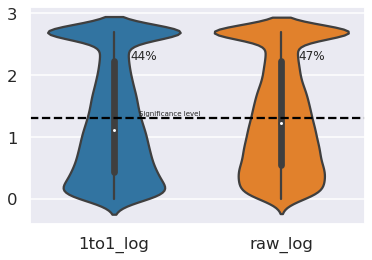

In [318]:
percantage_replicating_df_non_melt.head()

log_methods = [m +'_log' for m in methods]
# percantage_replicating_df_non_melt[log_methods].head()
fig = sns.violinplot(data=percantage_replicating_df_non_melt[log_methods])
log_val = -np.round(np.log10(0.05),5)
fig.axhline(log_val, ls='--', c='black')
# fig.legend(loc = 'lower right')
fig.text(0.15,0.05+log_val, "Significance level",fontsize=7)
for i, m in enumerate(log_methods):
        repre = percantage_replicating_df_non_melt[percantage_replicating_df_non_melt[m]>log_val][m].count()/len(percantage_replicating_df_non_melt)
        print(repre)
        fig.text(0.1+i, 2.25,str(int(np.round(repre,2)*100))+'%', fontsize=12) #add text
# [m +'_log' for m in methods]


In [319]:
percantage_replicating_df_non_melt.columns

Index(['Metadata_broad_sample', 'ALL_SS_2_1to1', 'ALL_SS_2_raw',
       'ALL_SS_4_1to1', 'ALL_SS_4_raw', 'ALL_SS_6_1to1', 'ALL_SS_6_raw',
       'ALL_SS_8_1to1', 'ALL_SS_8_raw', 'ALL_SS_10_1to1', 'ALL_SS_10_raw',
       'ALL_SS_12_1to1', 'ALL_SS_12_raw', 'ALL_SS_14_1to1', 'ALL_SS_14_raw',
       'ALL_SS_16_1to1', 'ALL_SS_16_raw', 'ALL_SS_18_1to1', 'ALL_SS_18_raw',
       'ALL_SS_20_1to1', 'ALL_SS_20_raw', '1to1', 'raw', '1to1_log',
       'raw_log'],
      dtype='object')

0.0
0.0
0.4435487105442586
0.4717843821441463
0.0
0.0
0.4435487105442586
0.4717843821441463
0.0
0.0
0.4435487105442586
0.4717843821441463
0.0
0.0
0.4435487105442586
0.4717843821441463


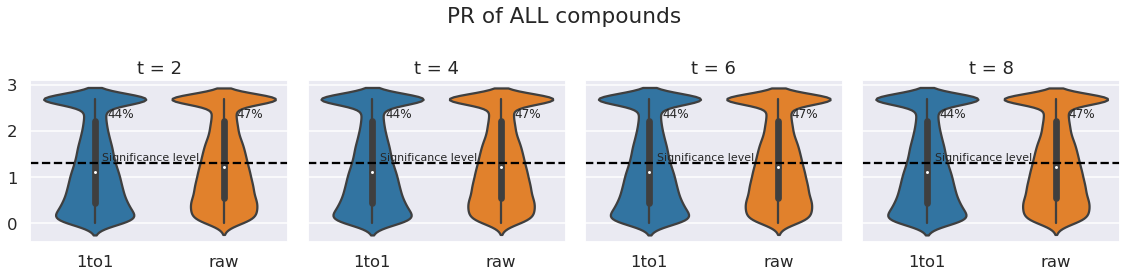

In [320]:
quantile_threshold = 0
ts = [2,4,6,8]



# fig.subplots_adjust(hspace=0.4, wspace=0.4)

fig, ax = plt.subplots(nrows=1, ncols=len(ts), figsize=(16,4), facecolor='#FFFFFF',sharey=True)
    
if quantile_threshold >0:
    fig.suptitle(f'PR of top {int((1-quantile_threshold)*100)}% compounds') 
else:
    fig.suptitle('PR of ALL compounds')
for i, t in enumerate(ts):
    violin = {}
    ind2={}
    ax[i].set_title(f't = {t}', fontsize = 18,y=1)
# for ax, method in zip(dis_plt.axes.flat, methods):
#         ax.text(0.1, 300,'Reproducable replicates: '+str(int(np.round(repr_score[method],6)*100))+'%', fontsize=15)
    min_num_samples = len(percantage_replicating_df_non_melt)
    for m in methods:
        
        quantile = percantage_replicating_df_non_melt[f'ALL_SS_{t}_{m}'].quantile(quantile_threshold)
        print(quantile)
        violin[m] = percantage_replicating_df_non_melt[percantage_replicating_df_non_melt[f'ALL_SS_{t}_{m}']>=quantile][f'{m}_log'].values
        ind2[m] = percantage_replicating_df_non_melt[percantage_replicating_df_non_melt[f'ALL_SS_{t}_{m}']>=quantile][f'{m}_log'].index
        num_samples_filtered = len(violin[m])
        min_num_samples = min(min_num_samples, num_samples_filtered)
        # print(min_num_samples)

    for m in methods:
        # print(len(violin[m]))
        violin[m] = violin[m][:min_num_samples]
        # print(len(violin[m]))

    violin_df = pd.DataFrame(violin)
    _=sns.violinplot(data=violin_df, ax=ax[i])

    
    # _ = sns.scatterplot(data=res_data, x=f'{chan}_SS_{t}_raw', y=f'{chan}_SS_{t}_map', alpha=0.6, )
    log_val = -np.round(np.log10(0.05),5)
    ax[i].axhline(log_val, ls='--', c='black')
    # fig.legend(loc = 'lower right')
    ax[i].text(0.06,0.05+log_val, "Significance level",fontsize=11)
    for j, m in enumerate(methods):

            repre = violin_df[violin_df[m]>log_val][m].count()/len(violin_df)
            # print(violin_df[violin_df[m]>log_val][m].count())
            # print(len(violin_df))
            print(repre)
            ax[i].text(0.1+j, 2.3,str(int(np.round(repre,2)*100))+'%', fontsize=12) #add text
    fig.tight_layout()
    # ax[i].show()


0.051775147928994
0.0007615279577045622
0.8322908522283033
0.8717748240813136
0.0088757396449704
0.00010503833899373255
0.8661916072842438
0.9259699129057799
0.0014792899408284
8.753194916144378e-06
0.8383645395491021
0.9174627435995415
0.0
0.0
0.4435487105442586
0.4717843821441463
0.0
0.0
0.4435487105442586
0.4717843821441463


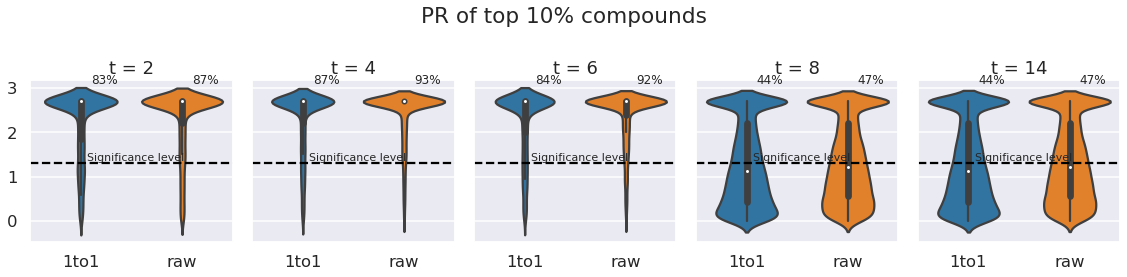

In [321]:
quantile_threshold = 0.9
ts = [2,4,6,8,14]



# fig.subplots_adjust(hspace=0.4, wspace=0.4)

fig, ax = plt.subplots(nrows=1, ncols=len(ts), figsize=(16,4), facecolor='#FFFFFF',sharey=True)
    
if quantile_threshold >0:
    fig.suptitle(f'PR of top {(1-quantile_threshold):.0%} compounds') 
else:
    fig.suptitle('PR of ALL compounds')
for i, t in enumerate(ts):
    violin = {}
    ind2={}
    ax[i].set_title(f't = {t}', fontsize = 18,y=1)
# for ax, method in zip(dis_plt.axes.flat, methods):
#         ax.text(0.1, 300,'Reproducable replicates: '+str(int(np.round(repr_score[method],6)*100))+'%', fontsize=15)
    min_num_samples = len(percantage_replicating_df_non_melt)
    for m in methods:
        
        quantile = percantage_replicating_df_non_melt[f'ALL_SS_{t}_{m}'].quantile(quantile_threshold)
        print(quantile)
        violin[m] = percantage_replicating_df_non_melt[percantage_replicating_df_non_melt[f'ALL_SS_{t}_{m}']>=quantile][f'{m}_log'].values
        ind2[m] = percantage_replicating_df_non_melt[percantage_replicating_df_non_melt[f'ALL_SS_{t}_{m}']>=quantile][f'{m}_log'].index
        num_samples_filtered = len(violin[m])
        min_num_samples = min(min_num_samples, num_samples_filtered)
        # print(min_num_samples)

    for m in methods:
        # print(len(violin[m]))
        violin[m] = violin[m][:min_num_samples]
        # print(len(violin[m]))

    violin_df = pd.DataFrame(violin)
    _=sns.violinplot(data=violin_df, ax=ax[i])

    
    # _ = sns.scatterplot(data=res_data, x=f'{chan}_SS_{t}_raw', y=f'{chan}_SS_{t}_map', alpha=0.6, )
    log_val = -np.round(np.log10(0.05),5)
    ax[i].axhline(log_val, ls='--', c='black')
    # fig.legend(loc = 'lower right')
    ax[i].text(0.06,0.05+log_val, "Significance level",fontsize=11)
    for j, m in enumerate(methods):

            repre = violin_df[violin_df[m]>log_val][m].count()/len(violin_df)
            # print(violin_df[violin_df[m]>log_val][m].count())
            # print(len(violin_df))
            print(repre)
            ax[i].text(0.1+j, 3.1,str(int(np.round(repre,2)*100))+'%', fontsize=12) #add text
    fig.tight_layout()
    # ax[i].show()


Method 1to1 Threshold 2 q:0.21
Method raw Threshold 2 q:0.00
0.896414342629482
0.9482071713147411
Method 1to1 Threshold 4 q:0.18
Method raw Threshold 4 q:0.00
0.8980392156862745
0.9647058823529412
Method 1to1 Threshold 6 q:0.15
Method raw Threshold 6 q:0.00
0.900398406374502
0.9721115537848606
Method 1to1 Threshold 8 q:0.12
Method raw Threshold 8 q:0.00
0.896414342629482
0.9760956175298805
Method 1to1 Threshold 14 q:0.06
Method raw Threshold 14 q:0.00
0.8924302788844621
0.9760956175298805


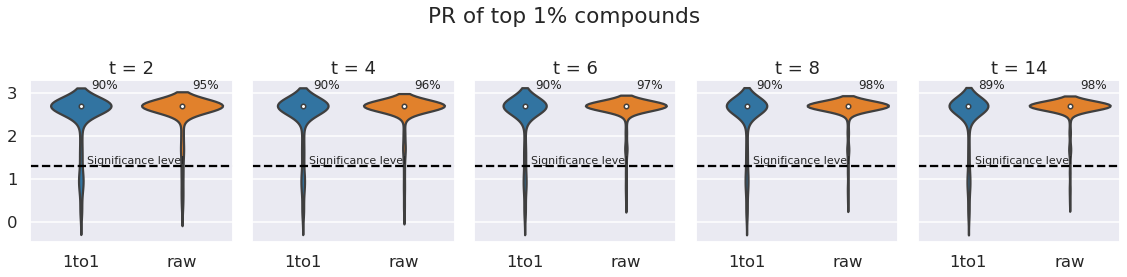

In [322]:


quantile_threshold = 0.99
ts = [2,4,6,8,14]



# fig.subplots_adjust(hspace=0.4, wspace=0.4)

fig, ax = plt.subplots(nrows=1, ncols=len(ts), figsize=(16,4), facecolor='#FFFFFF',sharey=True)
    
if quantile_threshold >0:
    fig.suptitle(f'PR of top {int((1-quantile_threshold)*100)}% compounds') 
else:
    fig.suptitle('PR of ALL compounds')
for i, t in enumerate(ts):
    violin = {}
    ind2={}
    ax[i].set_title(f't = {t}', fontsize = 18,y=1)
# for ax, method in zip(dis_plt.axes.flat, methods):
#         ax.text(0.1, 300,'Reproducable replicates: '+str(int(np.round(repr_score[method],6)*100))+'%', fontsize=15)
    min_num_samples = len(percantage_replicating_df_non_melt)
    for m in methods:
        
        quantile = percantage_replicating_df_non_melt[f'ALL_SS_{t}_{m}'].quantile(quantile_threshold)
        print(f'Method {m} Threshold {t} q:{quantile:.2f}')
        violin[m] = percantage_replicating_df_non_melt[percantage_replicating_df_non_melt[f'ALL_SS_{t}_{m}']>=quantile][f'{m}_log'].values
        ind2[m] = percantage_replicating_df_non_melt[percantage_replicating_df_non_melt[f'ALL_SS_{t}_{m}']>=quantile][f'{m}_log'].index
        num_samples_filtered = len(violin[m])
        min_num_samples = min(min_num_samples, num_samples_filtered)
        # print(min_num_samples)

    for m in methods:
        # print(len(violin[m]))
        violin[m] = violin[m][:min_num_samples]
        # print(len(violin[m]))

    violin_df = pd.DataFrame(violin)
    _=sns.violinplot(data=violin_df, ax=ax[i])

    
    # _ = sns.scatterplot(data=res_data, x=f'{chan}_SS_{t}_raw', y=f'{chan}_SS_{t}_map', alpha=0.6, )
    log_val = -np.round(np.log10(0.05),5)
    ax[i].axhline(log_val, ls='--', c='black')
    # fig.legend(loc = 'lower right')
    ax[i].text(0.06,0.05+log_val, "Significance level",fontsize=11)
    for j, m in enumerate(methods):

            repre = violin_df[violin_df[m]>log_val][m].count()/len(violin_df)
            # print(violin_df[violin_df[m]>log_val][m].count())
            # print(len(violin_df))
            print(repre)
            ax[i].text(0.1+j, 3.1,str(int(np.round(repre,2)*100))+'%', fontsize=12) #add text
    fig.tight_layout()
    # ax[i].show()


In [323]:
percantage_replicating_df[f'log10_p_val'] = - np.log10(percantage_replicating_df['p_val'])

/home/alonshp/.conda/envs/tf-env/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [324]:
percantage_replicating_df.head()
a = percantage_replicating_df.groupby('method').apply(lambda d: (d["log10_p_val"] >= 2).sum() / d.shape[0])
a

method
1to1    0.295231
raw     0.301368
dtype: float64

In [325]:
percantage_replicating_df_non_melt.head()

Metadata_broad_sample  ALL_SS_2_1to1  ALL_SS_2_raw  ALL_SS_4_1to1  \
0  BRD-A00037023-001-05-1       0.011834      0.000621       0.000000   
1  BRD-A00051892-001-05-0       0.007396      0.000131       0.000000   
2  BRD-A00214921-001-04-2       0.001479      0.000306       0.000000   
3  BRD-A00250346-001-05-0       0.016272      0.000473       0.001479   
4  BRD-A00430899-001-05-9       0.008876      0.000394       0.000000   

   ALL_SS_4_raw  ALL_SS_6_1to1  ALL_SS_6_raw  ALL_SS_8_1to1  ALL_SS_8_raw  \
0      0.000026            0.0      0.000000            0.0           0.0   
1      0.000000            0.0      0.000000            0.0           0.0   
2      0.000000            0.0      0.000000            0.0           0.0   
3      0.000009            0.0      0.000009            0.0           0.0   
4      0.000018            0.0      0.000000            0.0           0.0   

   ALL_SS_10_1to1  ...  ALL_SS_16_1to1  ALL_SS_16_raw  ALL_SS_18_1to1  \
0             0.0  ...             0.0            0.0             0.0   
1             0.0  ...             0.0            0.0             0.0   
2             0.0  ...             0.0            0.0             0.0   
3             0.0  ...             0.0            0.0             0.0   
4             0.0  ...             0.0            0.0             0.0   

   ALL_SS_18_raw  ALL_SS_20_1to1  ALL_SS_20_raw   1to1    raw  1to1_log  \
0            0.0             0.0            0.0  0.004  0.004  2.397940   
1            0.0             0.0            0.0  0.014  0.004  1.853872   
2            0.0             0.0            0.0  0.066  0.326  1.180456   
3            0.0             0.0            0.0  0.048  0.004  1.318759   
4            0.0             0.0            0.0  0.004  0.014  2.397940   

    raw_log  
0  2.397940  
1  2.397940  
2  0.486782  
3  2.397940  
4  1.853872  

[5 rows x 25 columns]

In [326]:
x=2
pr_methods = {}
pr_ss = pd.DataFrame([])
for m in methods:
    cols = ['Metadata_broad_sample',m,f'{m}_log'] + [col for col in percantage_replicating_df_non_melt.columns if f'ALL_SS_{x}_{m}' in col]
    # sens_t = sens_t[percantage_replicating_df_non_melt.filter(regex=f'ALL_SS_{x}_')
    pr_methods[m] = percantage_replicating_df_non_melt.loc[:,cols]
    pr_methods[m]['method'] = m
    pr_methods[m].rename(columns={'Metadata_broad_sample':'index',f'ALL_SS_{x}_{m}':'SS', m:'pval',f'{m}_log':'pval_log'},inplace=True)
    pr_ss = pd.concat([pr_ss, pr_methods[m]])
# pr_ss = pd.DataFrame(pr_methods)
pr_ss.head()
# len(pr_ss), len(percantage_replicating_df_non_melt)

index   pval  pval_log        SS method
0  BRD-A00037023-001-05-1  0.004  2.397940  0.011834   1to1
1  BRD-A00051892-001-05-0  0.014  1.853872  0.007396   1to1
2  BRD-A00214921-001-04-2  0.066  1.180456  0.001479   1to1
3  BRD-A00250346-001-05-0  0.048  1.318759  0.016272   1to1
4  BRD-A00430899-001-05-9  0.004  2.397940  0.008876   1to1

In [327]:
for i, t in enumerate(ts):
    violin = {}
    ind2={}
    
# for ax, method in zip(dis_plt.axes.flat, methods):
#         ax.text(0.1, 300,'Reproducable replicates: '+str(int(np.round(repr_score[method],6)*100))+'%', fontsize=15)
    min_num_samples = len(percantage_replicating_df_non_melt)
    for m in methods:
        
        quantile = percantage_replicating_df_non_melt[f'ALL_SS_{t}_{m}'].quantile(quantile_threshold)
        print(f'Method {m} Threshold {t} q:{quantile:.2f}')
        violin[m] = percantage_replicating_df_non_melt[percantage_replicating_df_non_melt[f'ALL_SS_{t}_{m}']>=quantile][f'{m}_log'].values
        ind2[m] = percantage_replicating_df_non_melt[percantage_replicating_df_non_melt[f'ALL_SS_{t}_{m}']>=quantile][f'{m}_log'].index
        num_samples_filtered = len(violin[m])
        min_num_samples = min(min_num_samples, num_samples_filtered)
        # print(min_num_samples)

Method 1to1 Threshold 2 q:0.21
Method raw Threshold 2 q:0.00
Method 1to1 Threshold 4 q:0.18
Method raw Threshold 4 q:0.00
Method 1to1 Threshold 6 q:0.15
Method raw Threshold 6 q:0.00
Method 1to1 Threshold 8 q:0.12
Method raw Threshold 8 q:0.00
Method 1to1 Threshold 14 q:0.06
Method raw Threshold 14 q:0.00


## Create melted representation of all metrics

In [328]:
ind_cols = ['index','method']
cols = ['index','method','SS', 'median_score', 'pval', 'pval_log']
melt_all = pd.merge(pr_ss, percantage_replicating_df, on=ind_cols)[cols]
melt_all.head()

index method        SS  median_score   pval  pval_log
0  BRD-A00037023-001-05-1   1to1  0.011834      0.275282  0.004  2.397940
1  BRD-A00051892-001-05-0   1to1  0.007396      0.202930  0.014  1.853872
2  BRD-A00214921-001-04-2   1to1  0.001479      0.139107  0.066  1.180456
3  BRD-A00250346-001-05-0   1to1  0.016272      0.146440  0.048  1.318759
4  BRD-A00430899-001-05-9   1to1  0.008876      0.277543  0.004  2.397940

In [329]:
melt_all[melt_all['method']=='raw'].head()

index method        SS  median_score   pval  pval_log
24933  BRD-A00037023-001-05-1    raw  0.000621      0.569141  0.004  2.397940
24934  BRD-A00051892-001-05-0    raw  0.000131      0.473362  0.004  2.397940
24935  BRD-A00214921-001-04-2    raw  0.000306      0.065320  0.326  0.486782
24936  BRD-A00250346-001-05-0    raw  0.000473      0.443761  0.004  2.397940
24937  BRD-A00430899-001-05-9    raw  0.000394      0.441979  0.014  1.853872

In [330]:
quantile_threshold = 0.99
melt_percentile = pd.DataFrame()
min_num_samples = len(percantage_replicating_df_non_melt)

for m in methods:

    quantile = melt_all[melt_all['method']==m]['SS'].quantile(quantile_threshold)
    print(f'Method {m} Threshold {t} q:{quantile:.2f}')
    percentile_method_df = melt_all[(melt_all['method']==m) & (melt_all['SS'] > quantile)]
    melt_percentile = pd.concat([melt_percentile, percentile_method_df])
    # violin[m] = percantage_replicating_df_non_melt[percantage_replicating_df_non_melt[f'ALL_SS_{t}_{m}']>=quantile][f'{m}_log'].values
    # ind2[m] = percantage_replicating_df_non_melt[percantage_replicating_df_non_melt[f'ALL_SS_{t}_{m}']>=quantile][f'{m}_log'].index
    # num_samples_filtered = len(violin[m])
    # min_num_samples = min(min_num_samples, num_samples_filtered)
    # print(min_num_samples)

Method 1to1 Threshold 14 q:0.21
Method raw Threshold 14 q:0.00


In [331]:
def rename_cols(df):
    'Rename columns from dose number to actual doses'
    
    df.sortname(columns= {'dose_1' : '0.04 uM', 'dose_2':'0.12 uM', 'dose_3':'0.37 uM',
                        'dose_4': '1.11 uM', 'dose_5':'3.33 uM', 'dose_6':'10 uM'}, inplace = True)
    return df

def melt_df(df, col_name):
    """
    This function returns a reformatted dataframe with 
    3 columns: cpd, dose number and dose_values(median score or p-value)
    """
    # df = df.melt(id_vars=['cpd', 'no_of_replicates'], var_name="dose", value_name=col_name)
    df = df.melt(id_vars=['cpd'], var_name="p_val", value_name=col_name)
    return df

def merge_p_median_vals(df_cpd_vals, df_null):
    """
    This function merge p_values and median scores 
    dataframes for each compound for all doses(1-6) 
    """
    df_p_vals = melt_df(df_null, 'p_values')
    df_cpd_vals = melt_df(df_cpd_vals, 'median_scores')
    df_cpd_vals['p_values'] = df_p_vals['p_values']
    return df_cpd_vals


In [332]:
def plot_p_vs_median(df, path, file_name,x_col="fraction_score", y_col="log10_p_val", percentile = 0,alpha=0.1):
    
    """plot p_values vs median correlation scores for each compound for all doses (1-6)"""
    
    if not os.path.exists(path):
        os.mkdir(path)
    plt.rcParams.update({'font.size': 12})
    plt.figure(figsize=(12,8)) 
    plt.xlabel(f"{x_col} scores of pairwise correlation btw cpds")
    plt.ylabel("Non-parametric -log10 P-values")
    plt.title(f"P-values vs {x_col} scores for compound replicates")
    # fig = sns.scatterplot(data=df, x="median_scores", y="p_values", hue="dose", 
    #                       style="dose", palette = "viridis")
    fig = sns.scatterplot(data=df, x=x_col, y=y_col, hue="method", 
                      style="method", palette = "viridis",alpha=alpha)
    
    significance_vals = [0.01,0.05,0.1]
    log_vals = [-np.log10(s) for s in significance_vals]
    
    min_x_val = df[x_col].min()
    max_x_val = df[x_col].max()
    x_range = max_x_val-min_x_val
    
    
    for i,log_val in enumerate(log_vals):
        reproduce = df.groupby('method').apply(lambda d: (d[y_col] >= log_val).sum() / d.shape[0])
        for j,r in enumerate(reproduce.keys()):
            fig.text(min_x_val+x_range/3,0.03+log_val+0.1*j, f"{r}: {reproduce[r]:.0%}")
        # df.groupby('method').apply(lambda d: (d[y_col] >= log_val).sum() / d.shape[0])
        if x_col == 'fraction_score':
            fig.text(min_x_val,0.03+log_val, f"Significance level: {significance_vals[i]}")
            fig.axhline(log_val, ls='--', c='black')
            fig.legend(loc = 'lower right')
        else:
            fig.text(min_x_val,0.03+log_val,  f"Significance level: {significance_vals[i]}")
            fig.axhline(log_val, ls='--', c='black')
            fig.legend(loc = 'lower right')
    
    
    
    plt.savefig(os.path.join(path, file_name))
    plt.show()
    
percantage_replicating_df.columns

Index(['Unnamed: 0', 'index', 'method', 'median_score', 'p_val',
       'log10_p_val'],
      dtype='object')

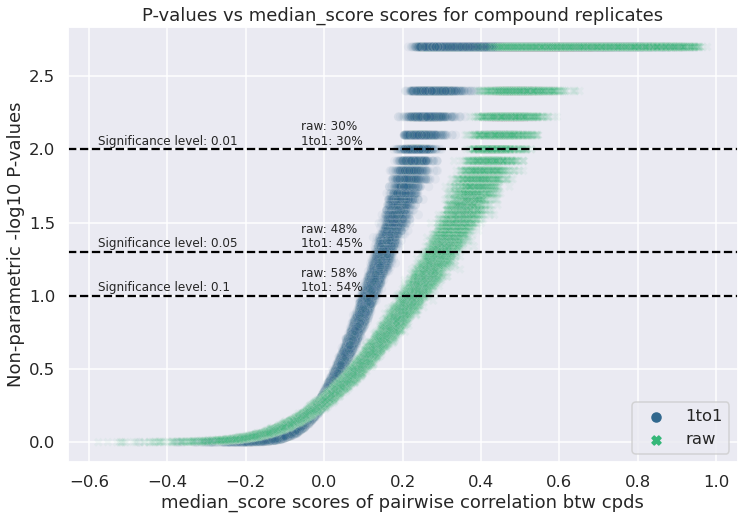

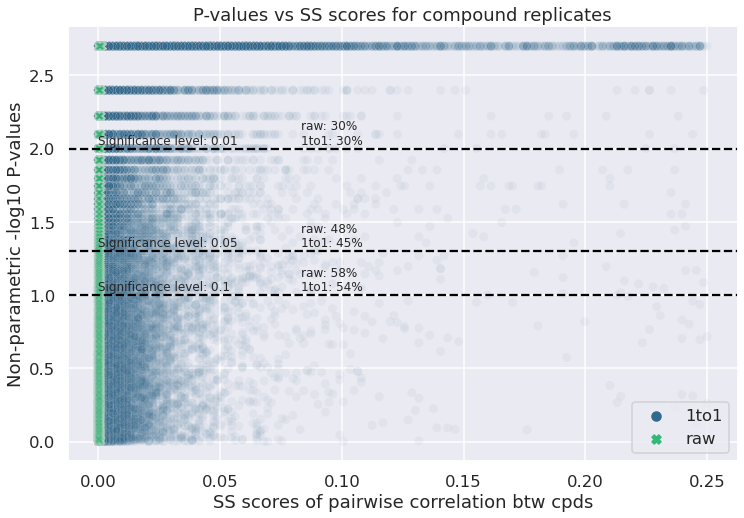

In [333]:
# percantage_replicating_df = percantage_replicating_df[percantage_replicating_df['method']!='raw1to1']
alpha = 0.05
plot_p_vs_median(melt_all,'cellpainting_figures', 'p_vs_median.png',x_col="median_score",y_col='pval_log', alpha=alpha)
plot_p_vs_median(melt_all,'cellpainting_figures', 'p_vs_fraction.png', x_col="SS",y_col='pval_log', alpha=alpha)


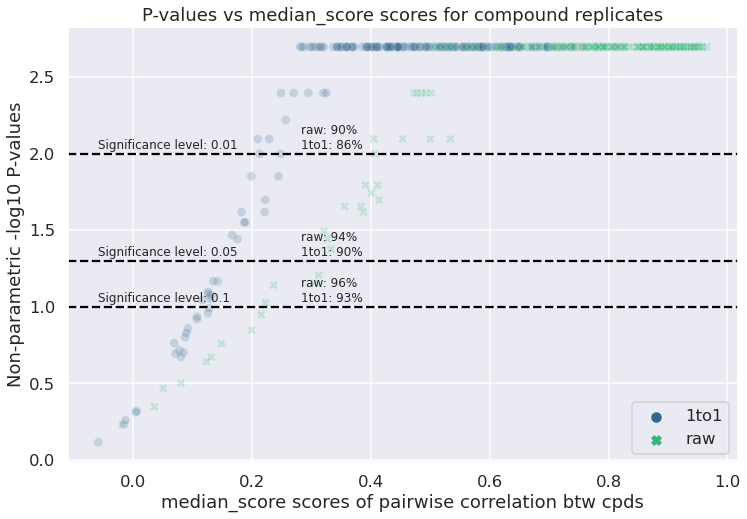

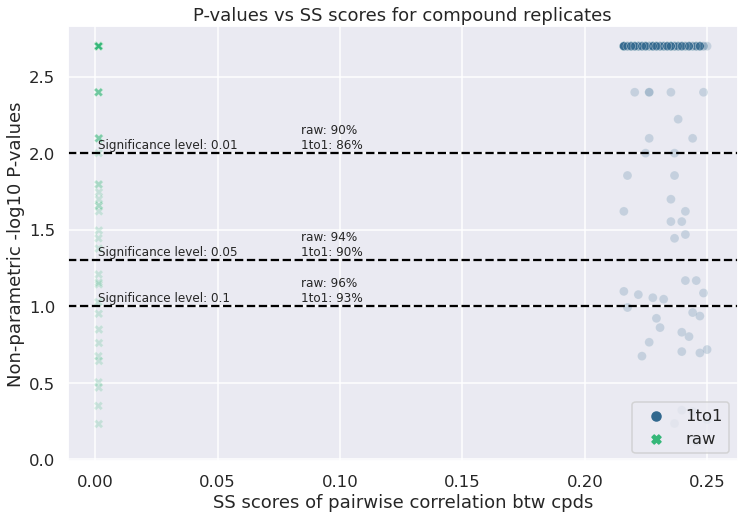

In [334]:
# percantage_replicating_df = percantage_replicating_df[percantage_replicating_df['method']!='raw1to1']
alpha = 0.2
plot_p_vs_median(melt_percentile,'cellpainting_figures', 'p_vs_median.png',x_col="median_score",y_col='pval_log', alpha=alpha)
plot_p_vs_median(melt_percentile,'cellpainting_figures', 'p_vs_fraction.png', x_col="SS",y_col='pval_log', alpha=alpha)


/home/alonshp/.conda/envs/tf-env/lib/python3.8/site-packages/seaborn/distributions.py:1210: UserWarning: No contour levels were found within the data range.
  cset = contour_func(


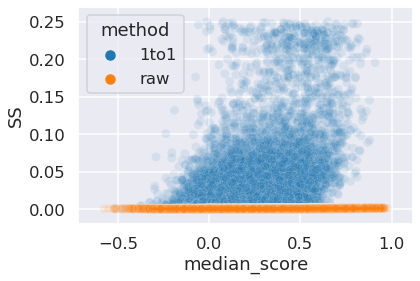

In [335]:
ax = sns.kdeplot(data=melt_all, x='median_score', y='SS',hue='method')
ax = sns.scatterplot(data=melt_all, x='median_score', y='SS',hue='method',alpha=0.1)
# ax.plot([-0.5,3.5],[-0.5,3.5], 'r--')

/home/alonshp/.conda/envs/tf-env/lib/python3.8/site-packages/seaborn/distributions.py:1210: UserWarning: No contour levels were found within the data range.
  cset = contour_func(


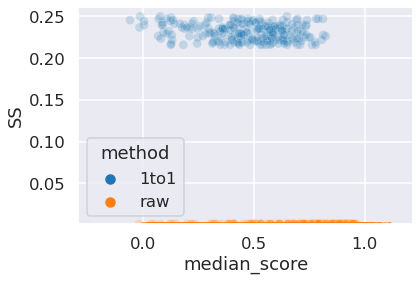

In [336]:
ax = sns.kdeplot(data=melt_percentile, x='median_score', y='SS',hue='method')
ax = sns.scatterplot(data=melt_percentile, x='median_score', y='SS',hue='method',alpha=0.2)
# ax.set(ylim=(0.1, 0.27))

In [337]:
unreproduce_hits = pr_ss[(pr_ss['method'] == '1to1') & (pr_ss['SS']>0.2) & (pr_ss['pval']>0.1)]
int((len(unreproduce_hits)/len(percantage_replicating_df_non_melt) ) * len(percantage_replicating_df_non_melt) )


20

In [338]:
unreproduce_hits_idx = unreproduce_hits['index']
unreproduce_hits_idx

722      BRD-A39737108-003-05-5
2390     BRD-K02615925-003-06-3
3058     BRD-K05711643-001-06-2
3510     BRD-K07669546-001-05-0
3629     BRD-K08227755-001-05-2
3665     BRD-K08409398-001-06-7
3890     BRD-K09460252-001-01-5
4835     BRD-K13847800-001-05-5
5330     BRD-K16038004-003-06-6
5698     BRD-K17705806-003-01-0
12434    BRD-K46449123-001-01-0
17287    BRD-K67258146-001-01-2
18475    BRD-K72336314-001-06-4
19169    BRD-K75464194-001-04-1
20209    BRD-K79857601-001-09-8
20506    BRD-K81174269-001-04-8
22091    BRD-K88133561-001-06-7
22546    BRD-K90053518-001-07-5
22774    BRD-K91188267-001-05-5
23961    BRD-K96341939-003-05-9
Name: index, dtype: object

In [339]:
zscores['1to1']['all'].head()
for idx in unreproduce_hits_idx:
    trt_samples = zscores['1to1']['all'].loc[:,:,idx,:]
    
    

In [340]:
# zscores['1to1']['all'].loc[:,:,'BRD-K17705806-003-01-0',:]
z = zscores['1to1']['trt'].loc[:,:,unreproduce_hits_idx.values[0],:]
z = z.reindex(sorted(z.columns), axis=1)
z

Cells_Granularity_1_AGP  \
Plate Metadata_ASSAY_WELL_ROLE Image_Metadata_Well                            
25689 treated                  o14                                      1.0   
25690 treated                  o14                                      1.0   
25692 treated                  o14                                      1.0   
25724 treated                  o14                                      1.0   

                                                    Cells_Granularity_1_ER  \
Plate Metadata_ASSAY_WELL_ROLE Image_Metadata_Well                           
25689 treated                  o14                                     1.0   
25690 treated                  o14                                     1.0   
25692 treated                  o14                                     1.0   
25724 treated                  o14                                     0.0   

                                                    Cells_Granularity_1_Mito  \
Plate Metadata_ASSAY_WELL_ROLE Image_Metadata_Well                             
25689 treated                  o14                                       1.0   
25690 treated                  o14                                       1.0   
25692 treated                  o14                                       0.0   
25724 treated                  o14                                       0.0   

                                                    Cells_Granularity_1_RNA  \
Plate Metadata_ASSAY_WELL_ROLE Image_Metadata_Well                            
25689 treated                  o14                                      1.0   
25690 treated                  o14                                      1.0   
25692 treated                  o14                                      1.0   
25724 treated                  o14                                      1.0   

                                                    Cells_Intensity_IntegratedIntensityEdge_AGP  \
Plate Metadata_ASSAY_WELL_ROLE Image_Metadata_Well                                                
25689 treated                  o14                                                          1.0   
25690 treated                  o14                                                          1.0   
25692 treated                  o14                                                          1.0   
25724 treated                  o14                                                          0.0   

                                                    Cells_Intensity_IntegratedIntensityEdge_DNA  \
Plate Metadata_ASSAY_WELL_ROLE Image_Metadata_Well                                                
25689 treated                  o14                                                          1.0   
25690 treated                  o14                                                          1.0   
25692 treated                  o14                                                          1.0   
25724 treated                  o14                                                          0.0   

                                                    Cells_Intensity_IntegratedIntensityEdge_ER  \
Plate Metadata_ASSAY_WELL_ROLE Image_Metadata_Well                                               
25689 treated                  o14                                                         1.0   
25690 treated                  o14                                                         1.0   
25692 treated                  o14                                                         1.0   
25724 treated                  o14                                                         0.0   

                                                    Cells_Intensity_IntegratedIntensityEdge_Mito  \
Plate Metadata_ASSAY_WELL_ROLE Image_Metadata_Well                                                 
25689 treated                  o14                                                           1.0   
25690 treated                  o14                                       

In [341]:
melt_all[(melt_all['index']==unreproduce_hits_idx.values[0]) & (melt_all['method']=='1to1')]['SS'].values[0]


0.2426035502958579

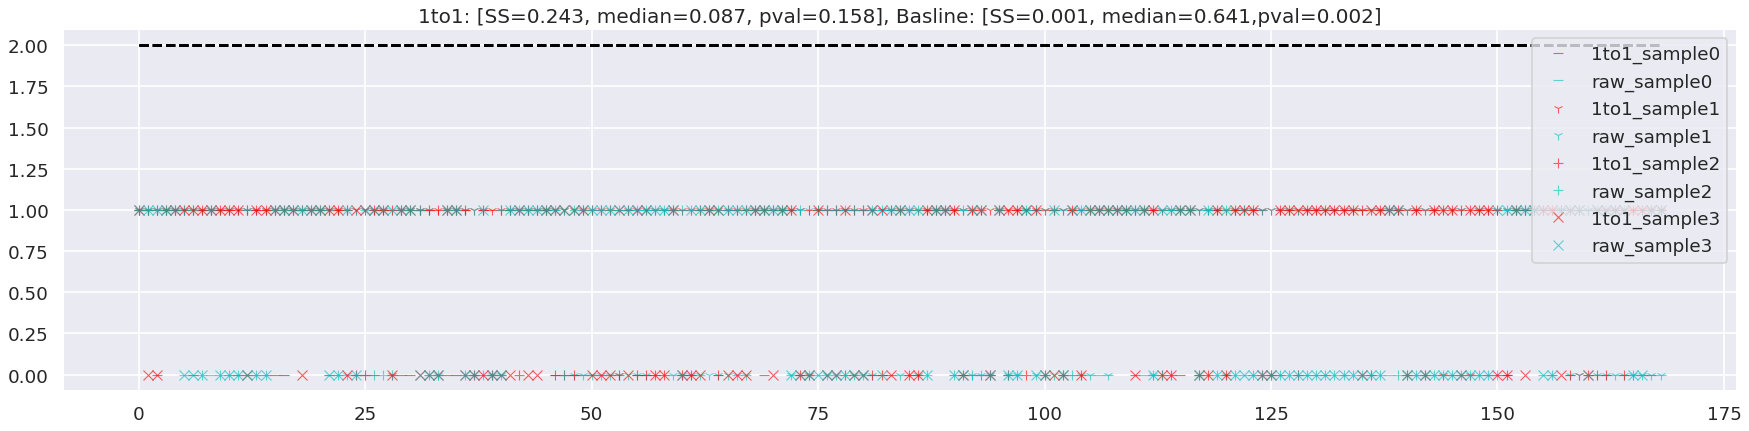

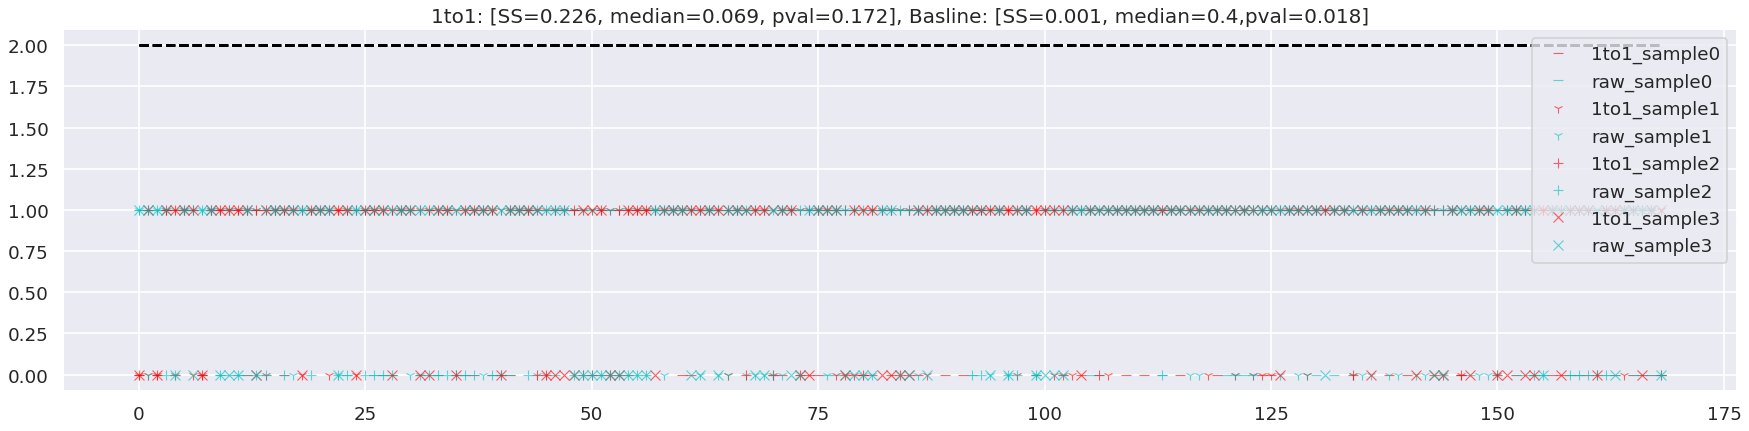

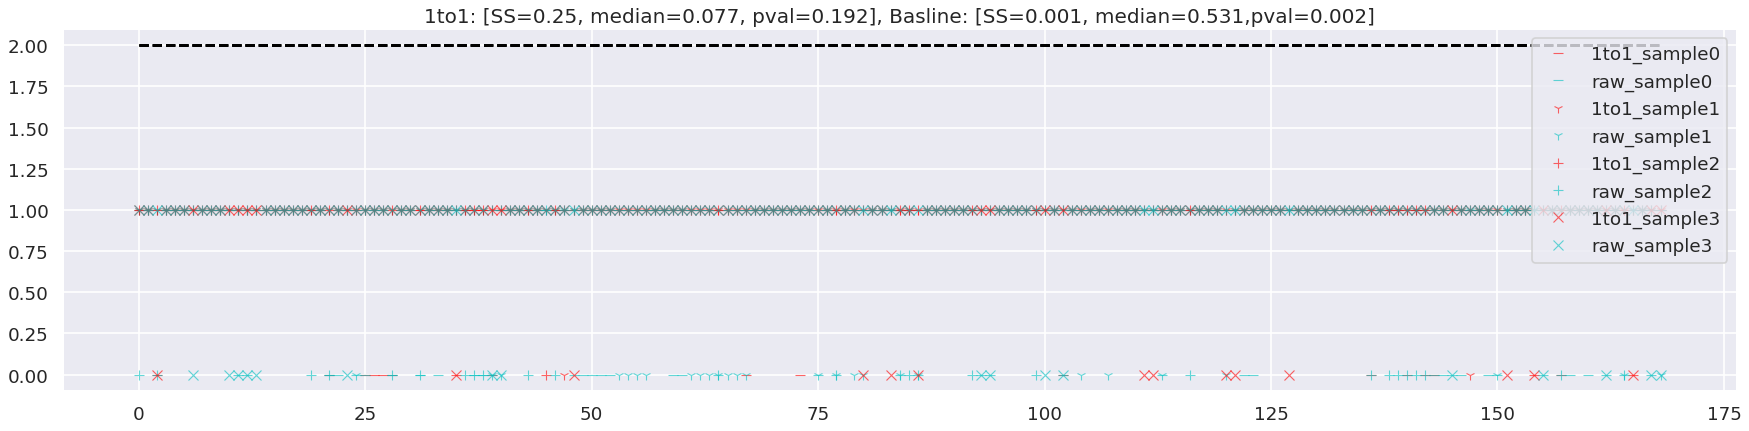

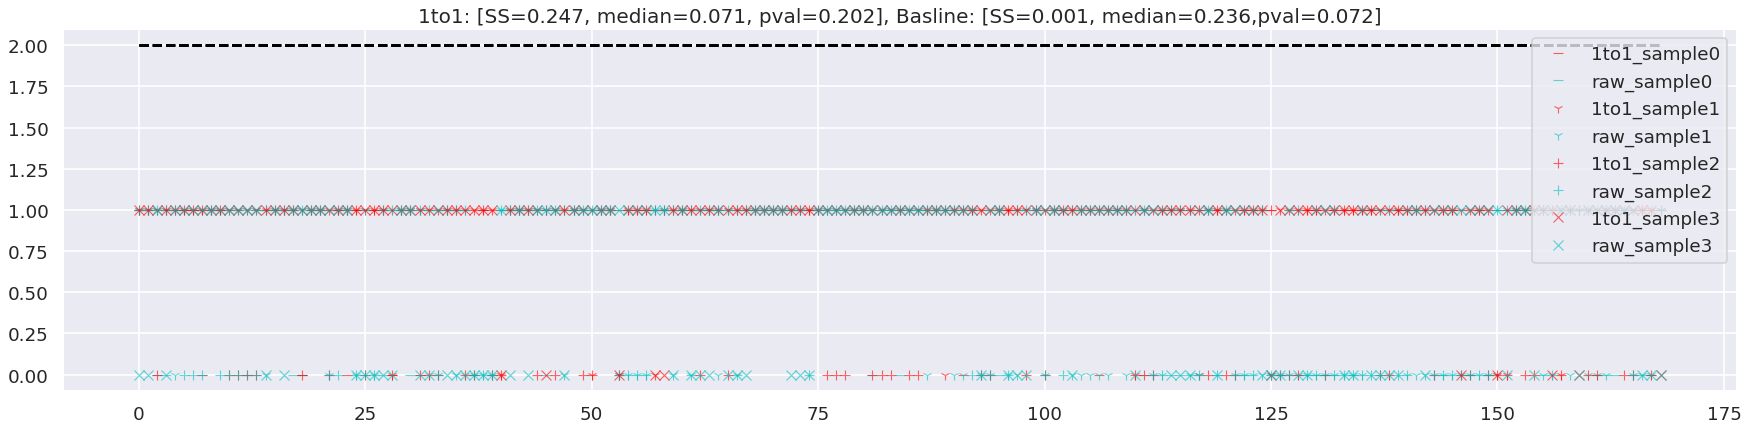

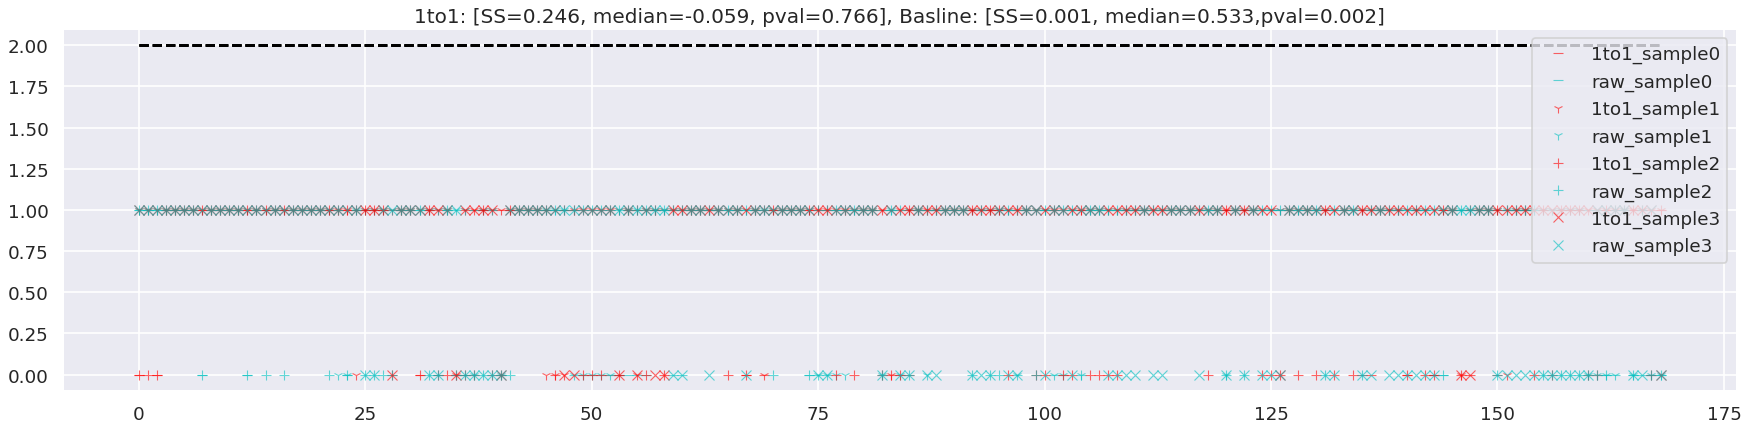

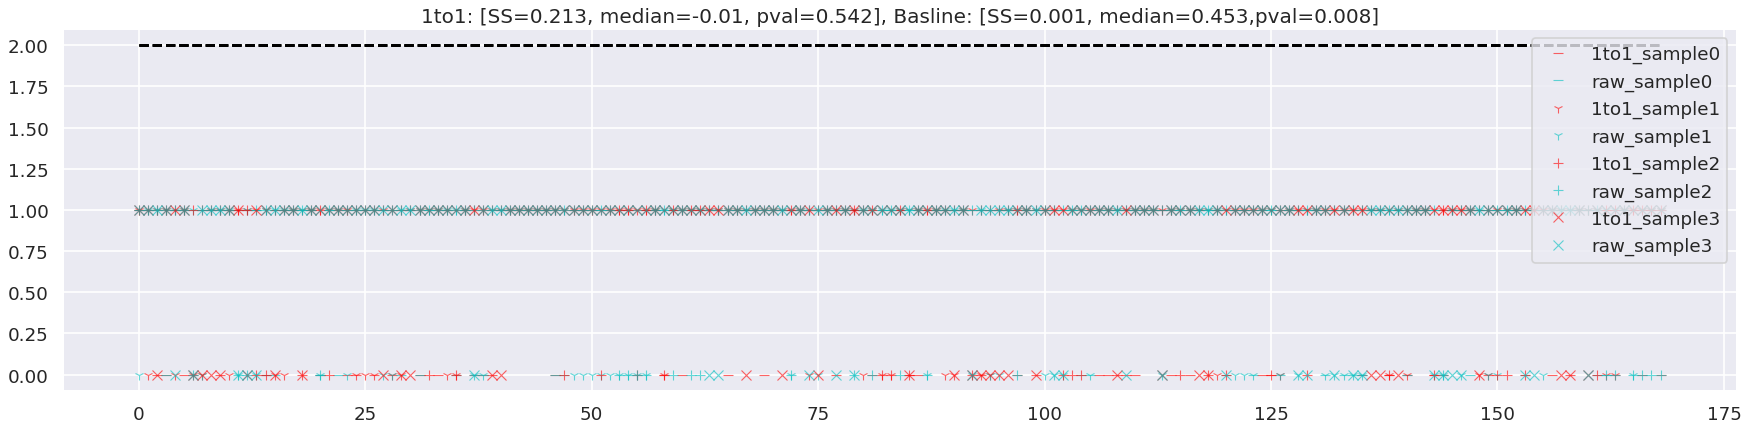

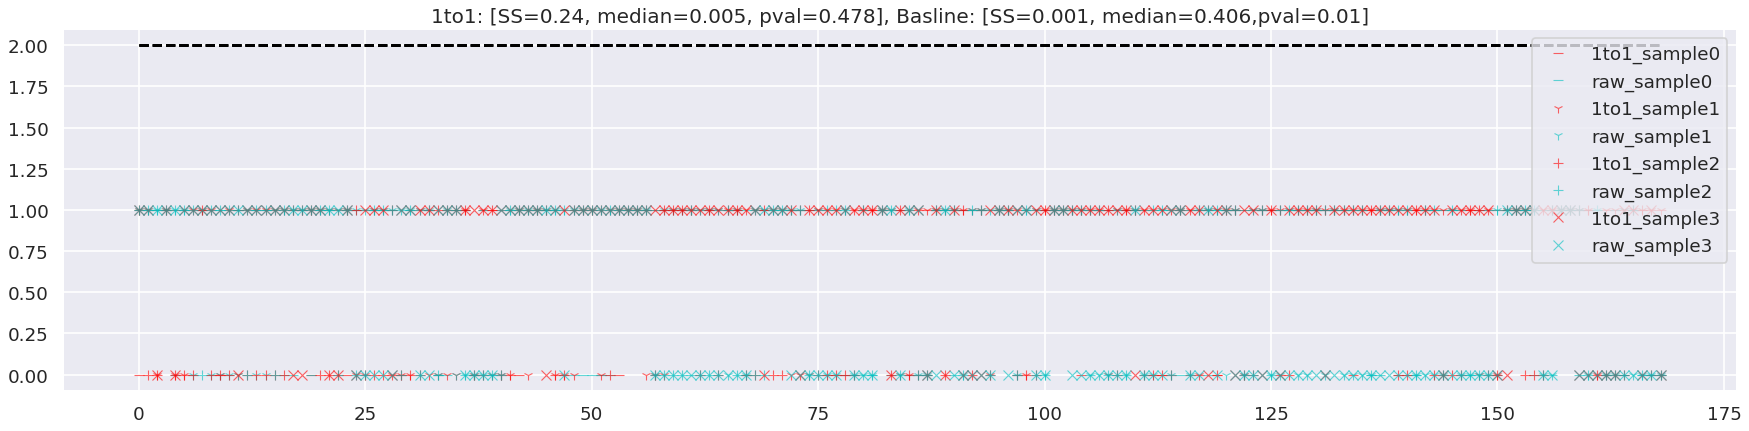

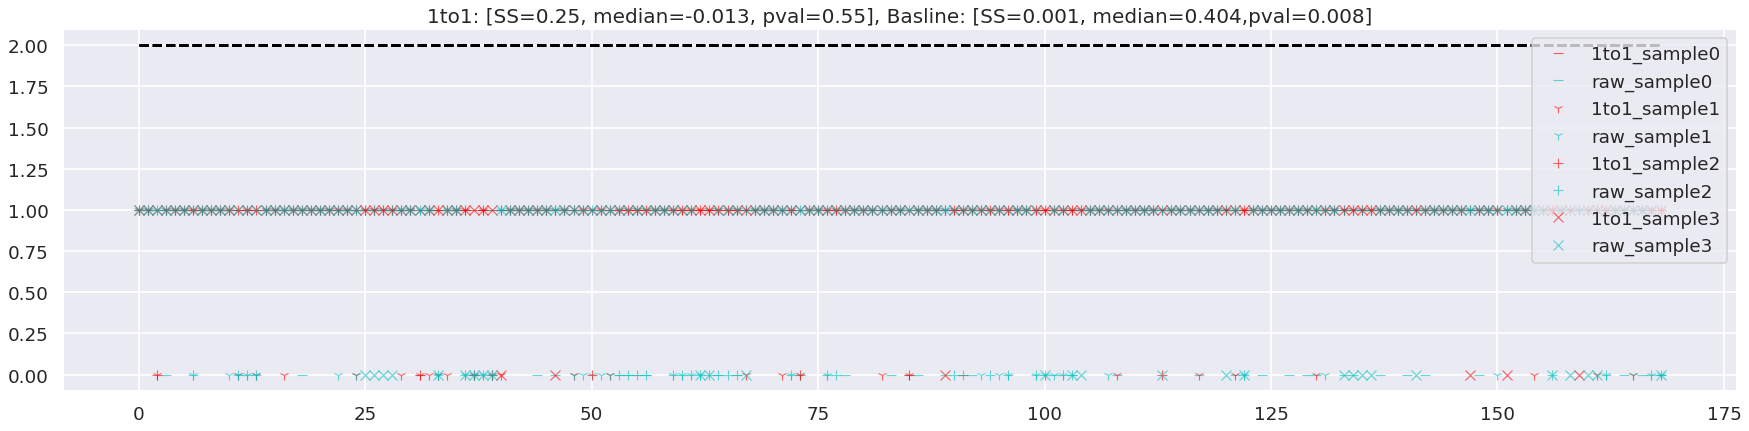

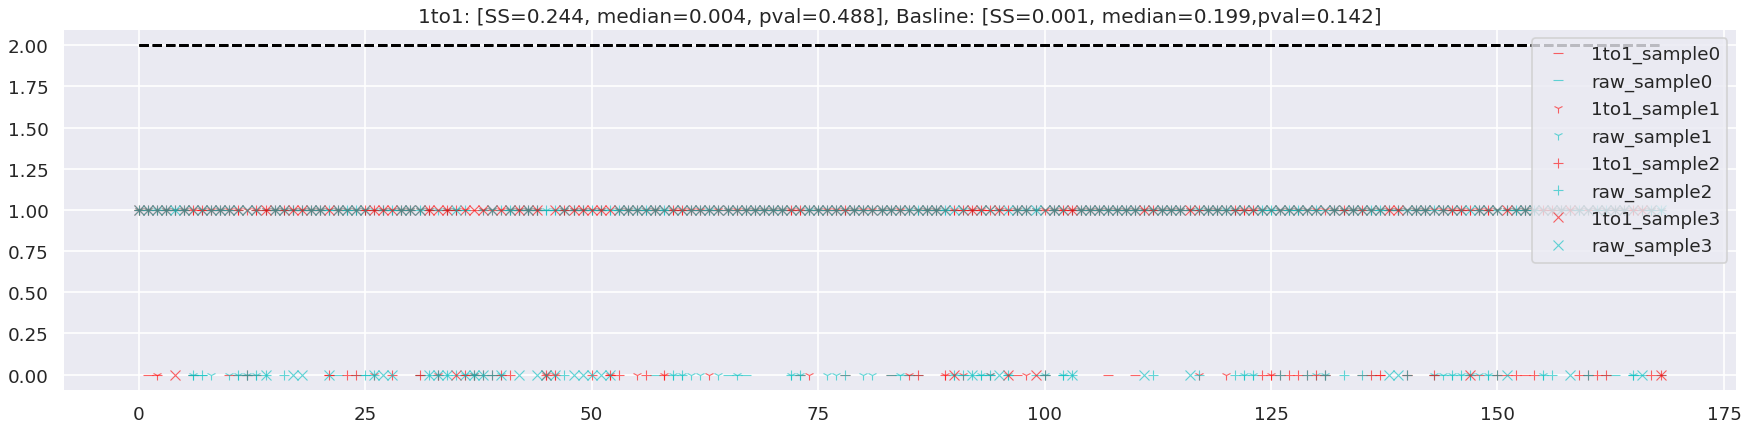

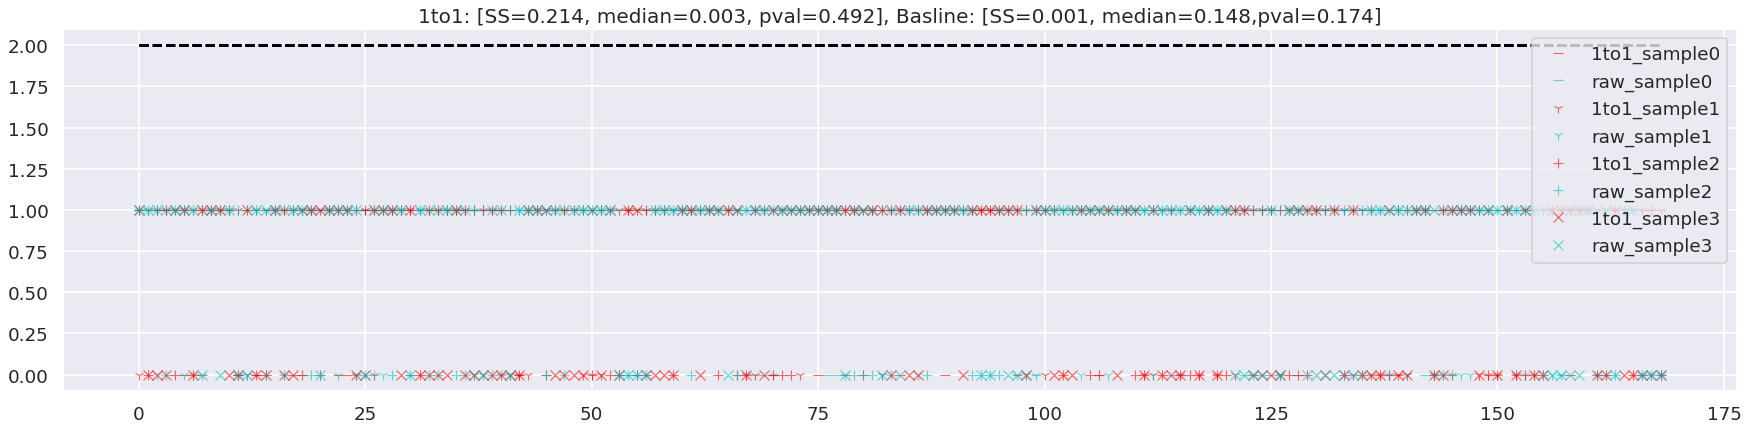

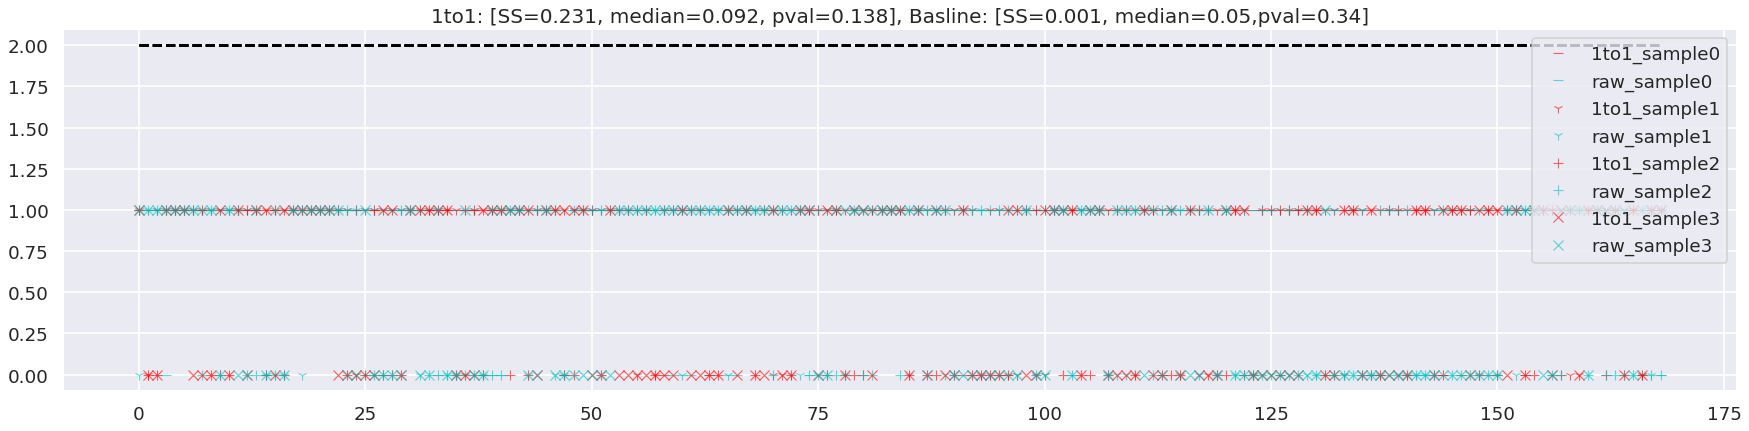

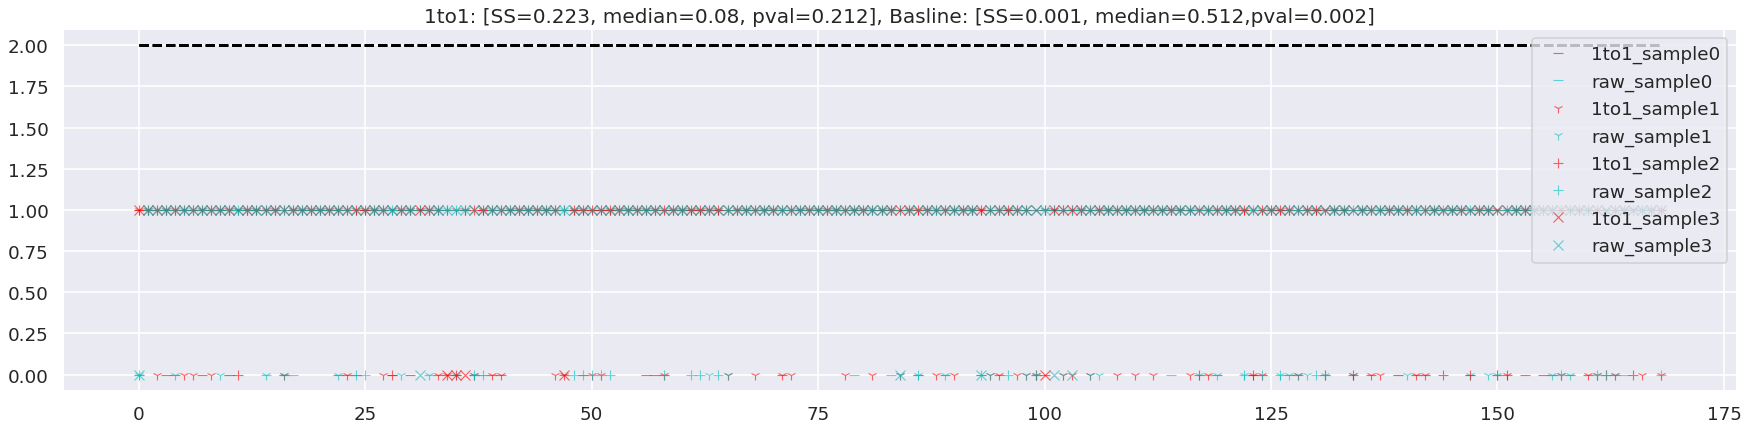

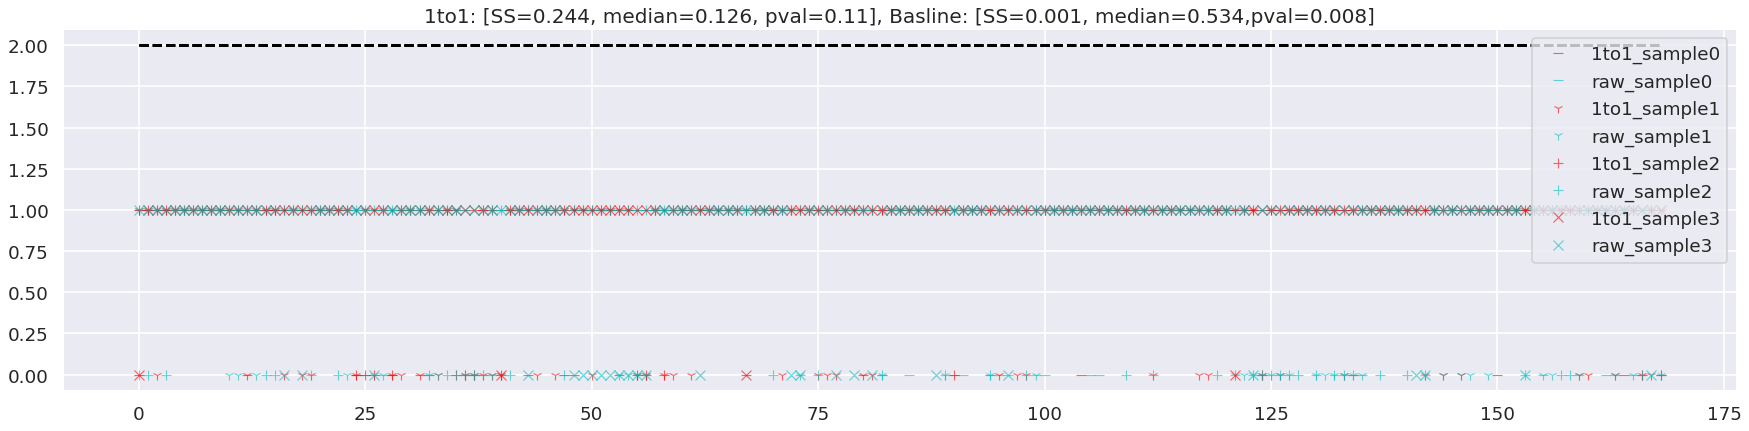

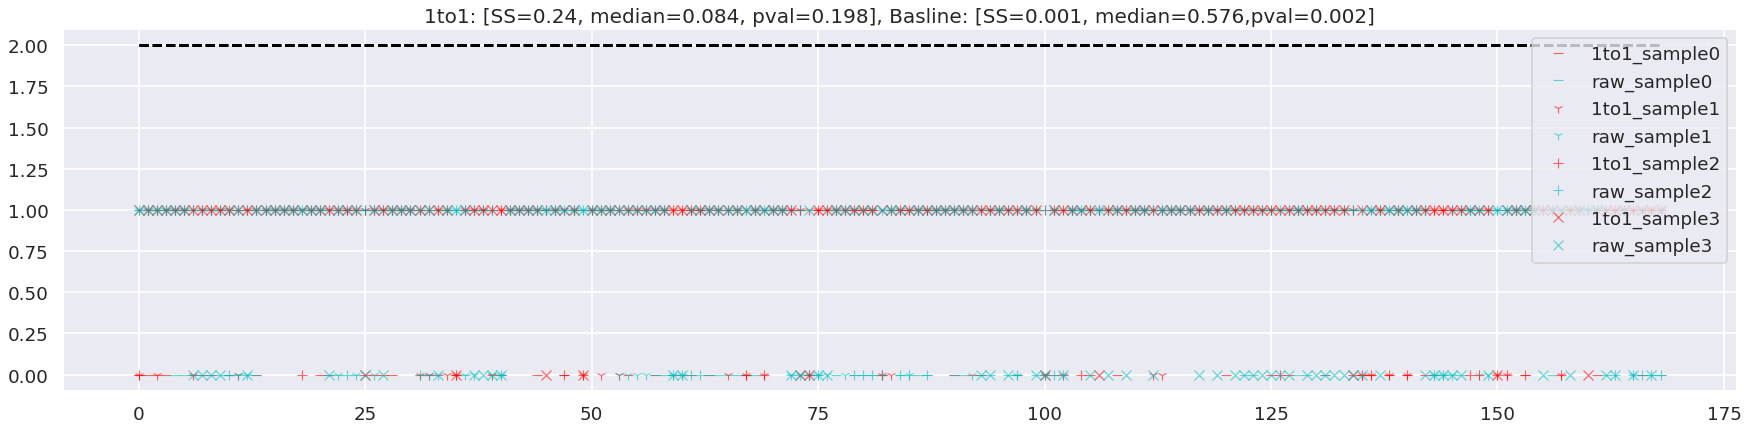

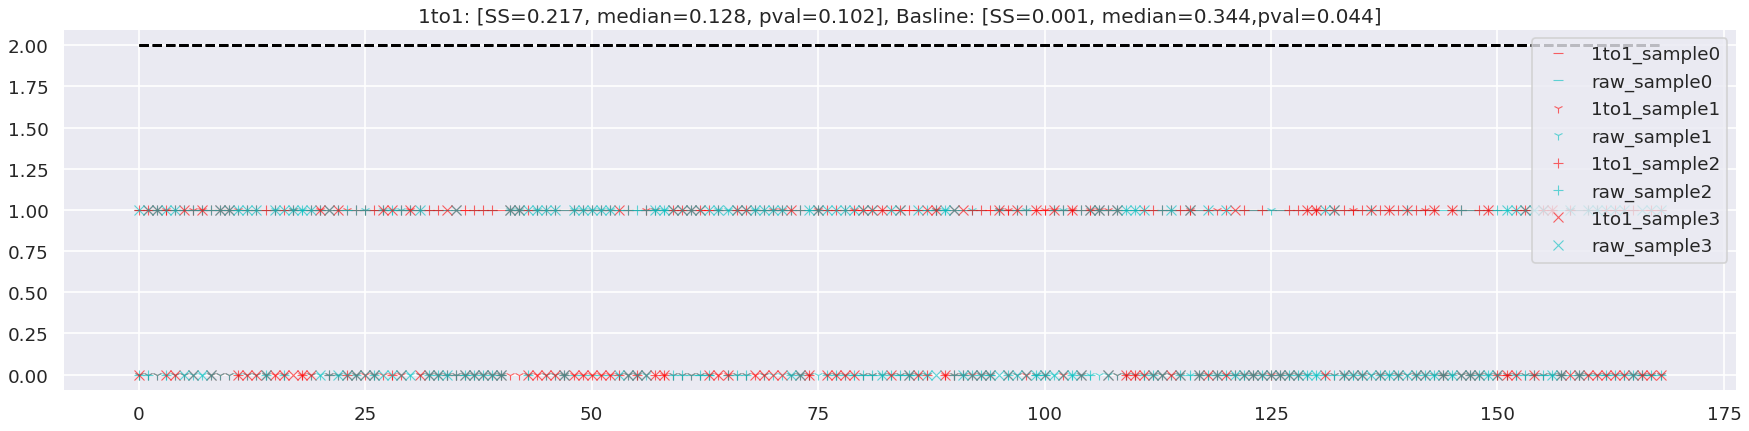

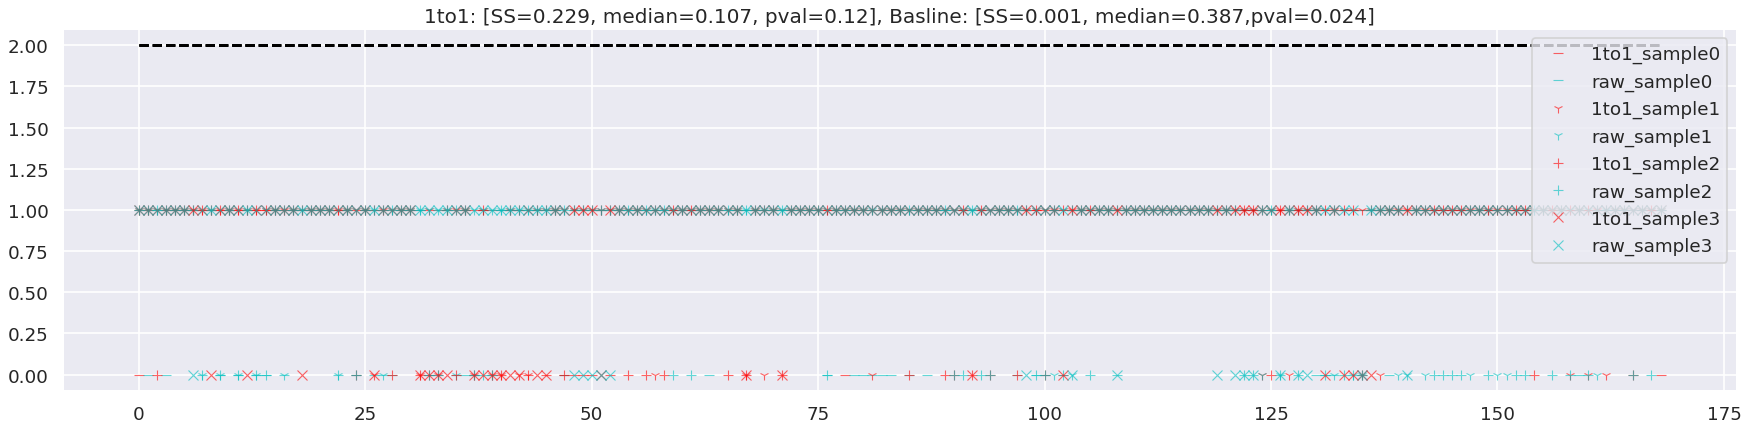

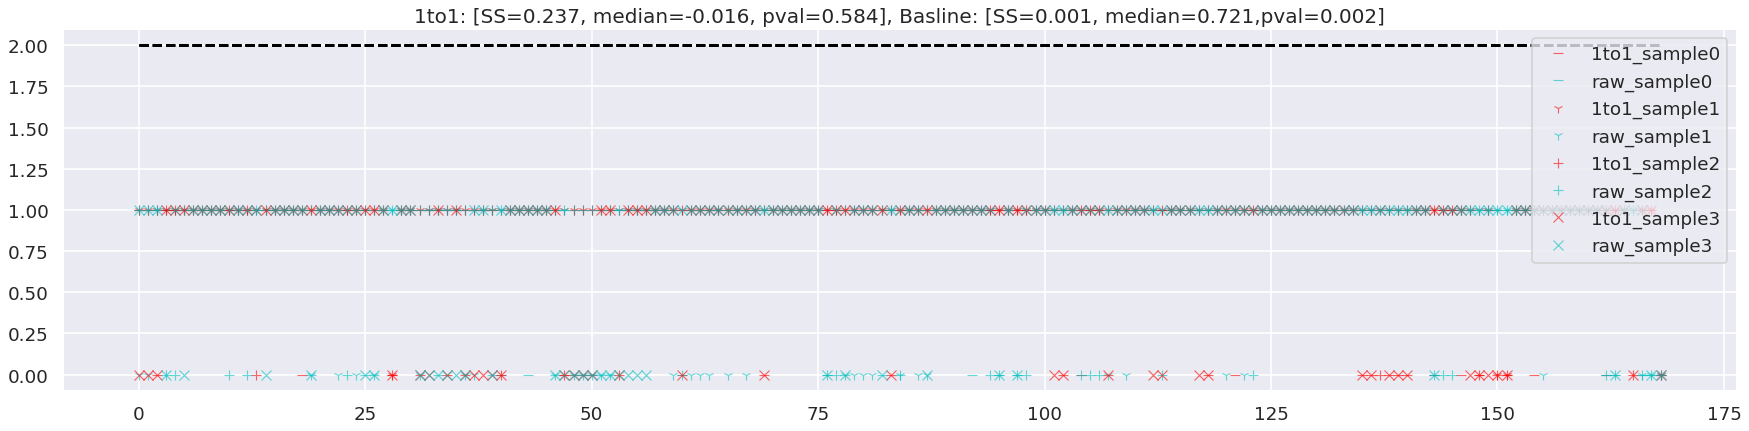

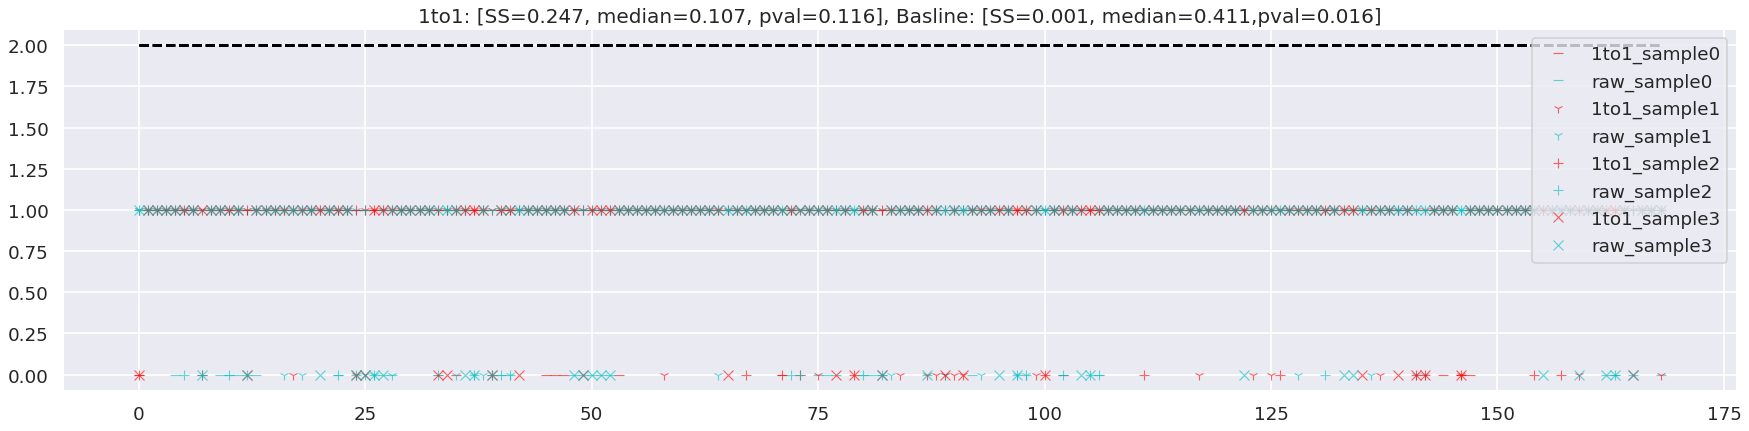

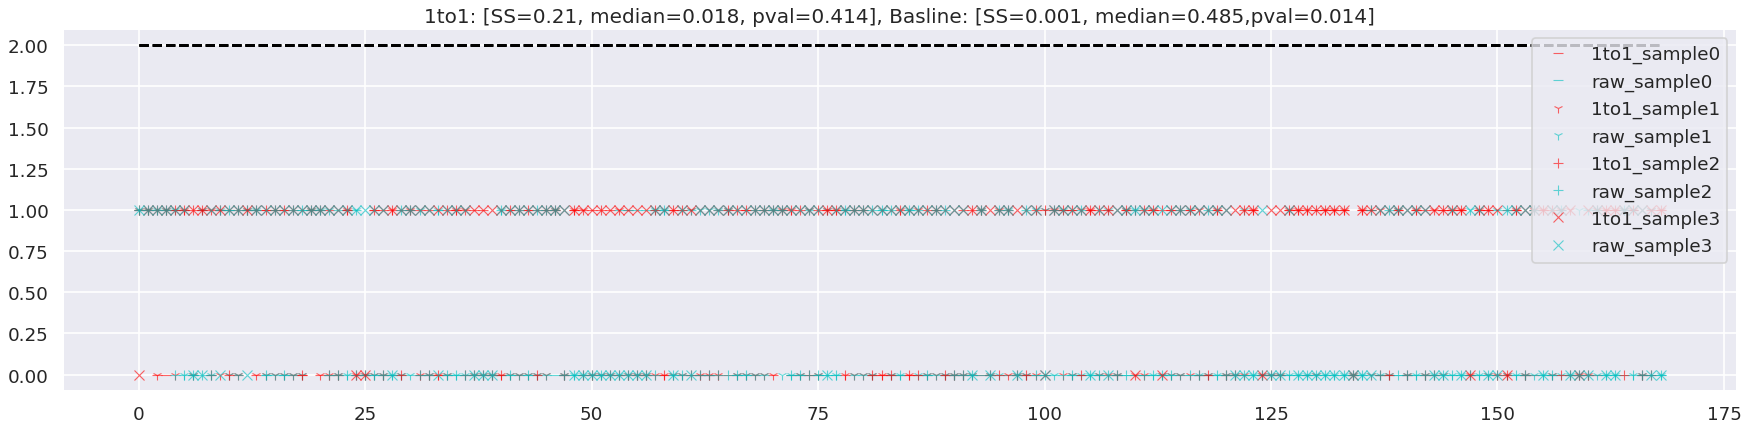

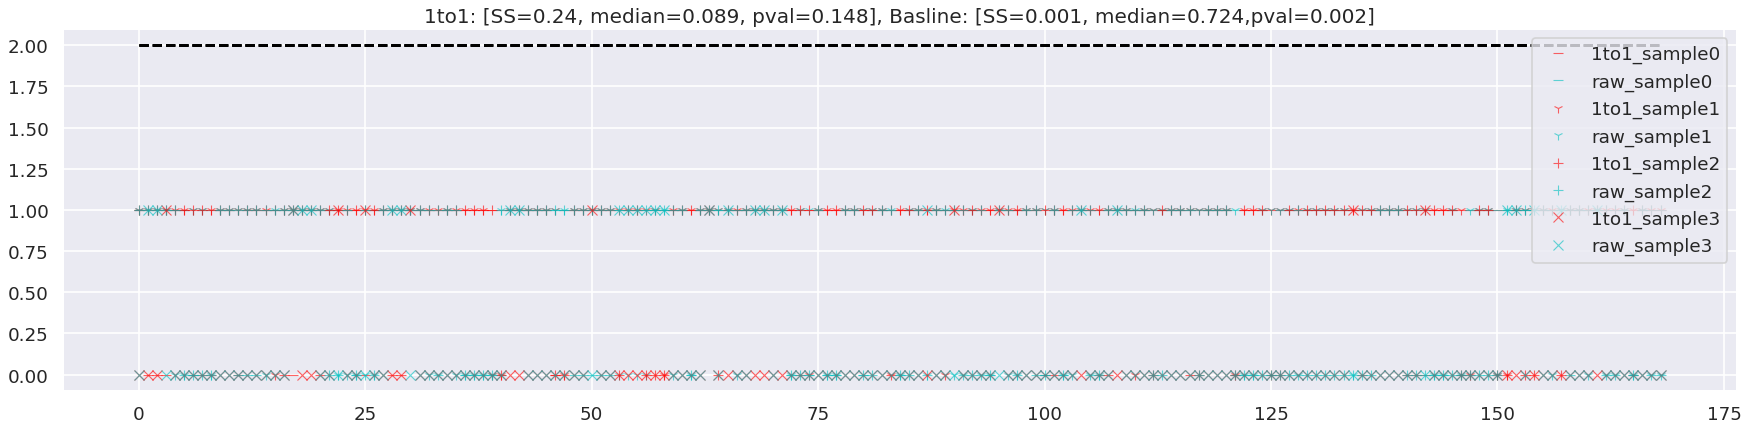

In [345]:
# zscores['raw']['trt'].loc[:,:,unreproduce_hits_idx.values[0],:].values.shape
colors = ['r','b','g','c']


markers = ["_", "1","+","x"]

for u in range(len(unreproduce_hits_idx)):
    plt.figure(figsize=(27, 6), dpi=80)
    for i in range(len(colors)):
        y1 = zscores['1to1']['trt'].loc[:,:,unreproduce_hits_idx.values[u],:].values[i,:]
        y1_ss = melt_all[(melt_all['index']==unreproduce_hits_idx.values[u]) & (melt_all['method']=='1to1')]['SS'].values[0]
        y1_median = melt_all[(melt_all['index']==unreproduce_hits_idx.values[u]) & (melt_all['method']=='1to1')]['median_score'].values[0]
        y1_pval = melt_all[(melt_all['index']==unreproduce_hits_idx.values[u]) & (melt_all['method']=='1to1')]['pval'].values[0]
        
        y2 = zscores['raw']['trt'].loc[:,:,unreproduce_hits_idx.values[u],:].values[i,:]
        y2_ss = melt_all[(melt_all['index']==unreproduce_hits_idx.values[u]) & (melt_all['method']=='raw')]['SS'].values[0]
        y2_median = melt_all[(melt_all['index']==unreproduce_hits_idx.values[u]) & (melt_all['method']=='raw')]['median_score'].values[0]
        y2_pval = melt_all[(melt_all['index']==unreproduce_hits_idx.values[u]) & (melt_all['method']=='raw')]['pval'].values[0]
        
        x = range(len(y1))
        
        plt.plot(x, y1, color = 'r', linestyle='none', marker = markers[i],label=f"1to1_sample{i}",alpha=0.6)
        plt.plot(x, y2, color = 'c', linestyle='none' ,marker = markers[i], label =f"raw_sample{i}", alpha=0.6)
        plt.plot(x,[2]*len(x), color='black', linestyle='--')
        plt.title(f'1to1: [SS={np.round(y1_ss,3)}, median={np.round(y1_median,3)}, pval={np.round(y1_pval,3)}], Basline: [SS={np.round(y2_ss,3)}, median={np.round(y2_median,3)},pval={np.round(y2_pval,3)}]')
        plt.legend(loc='upper right')
        # plt.ylim([-20,60])
        # plt.xlim([0,169])
        

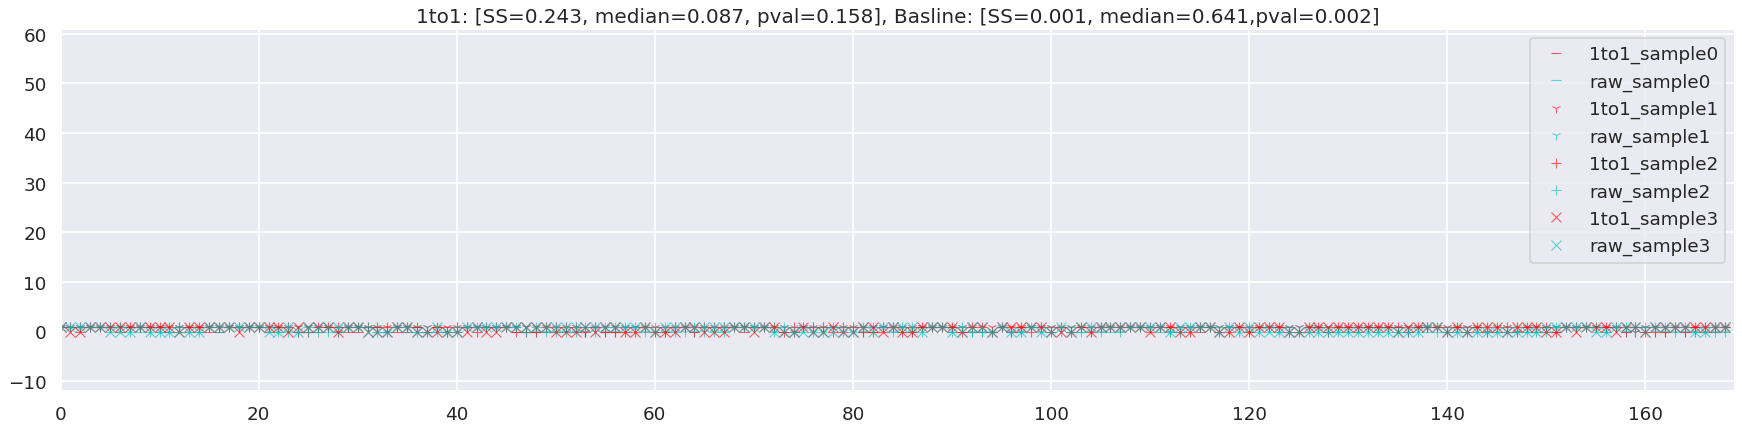

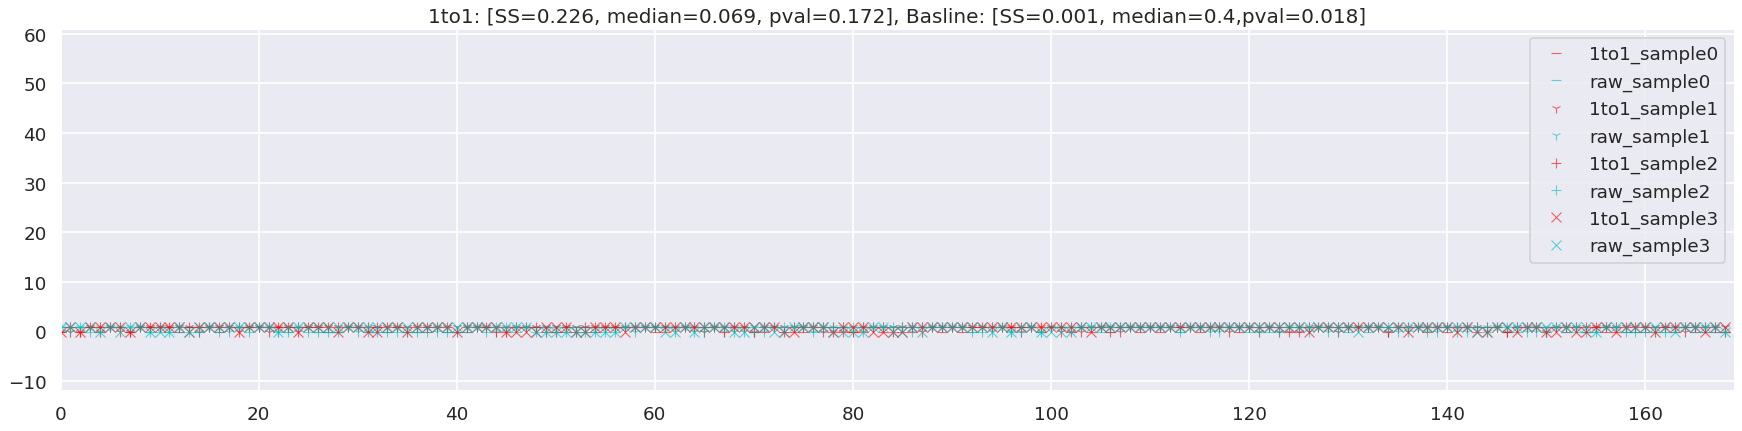

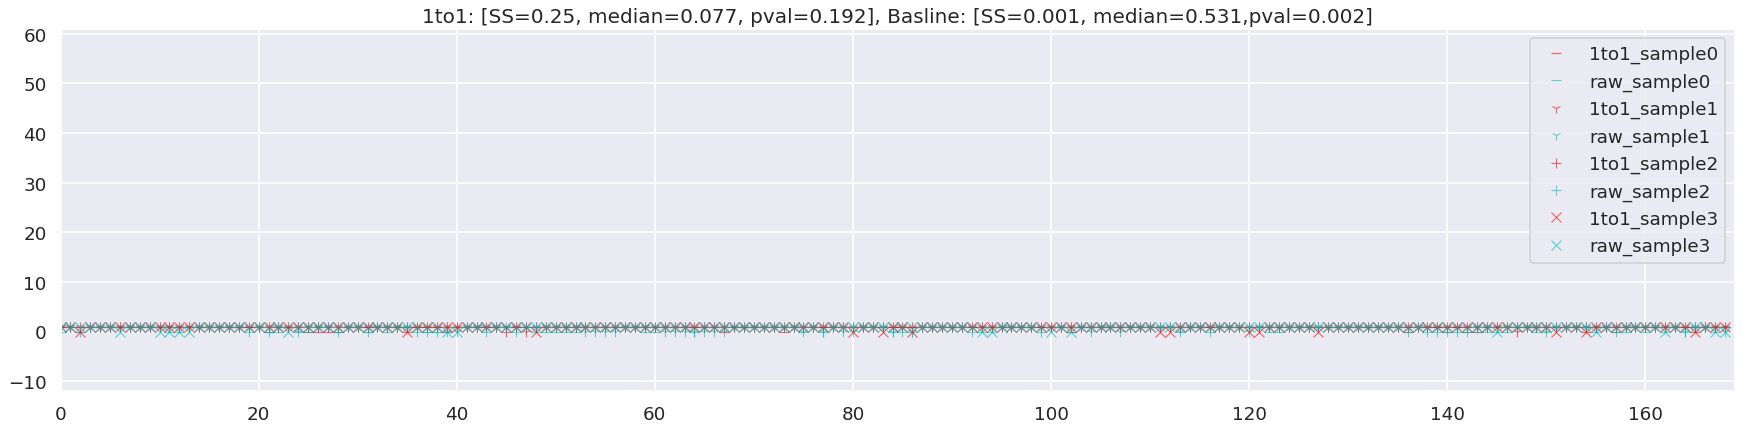

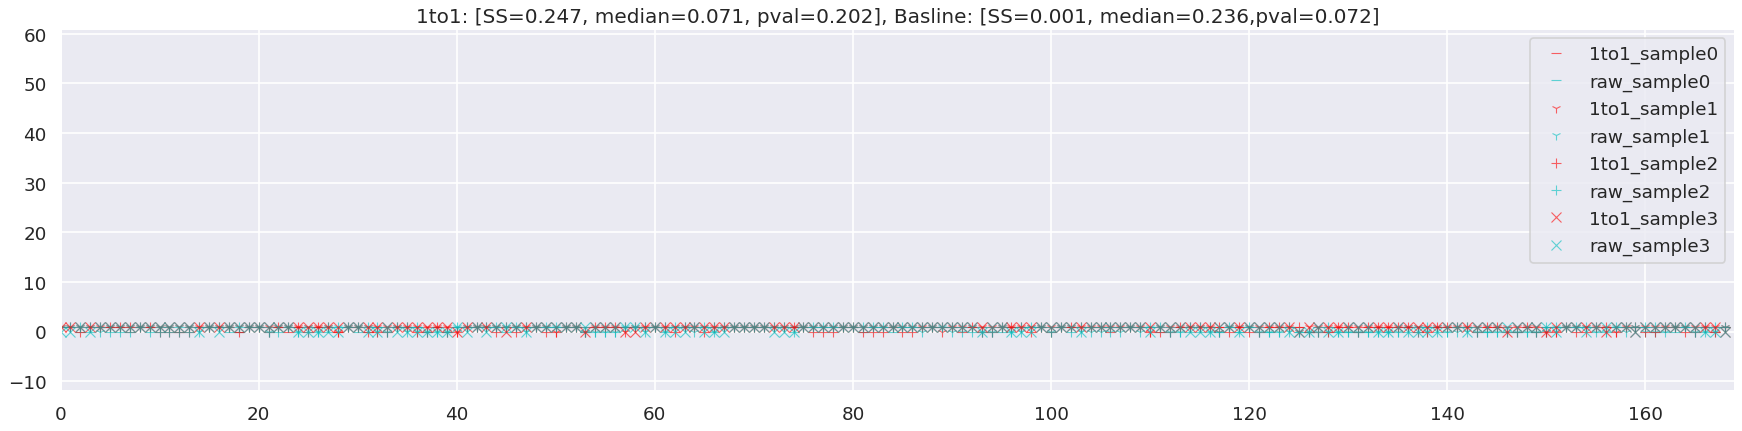

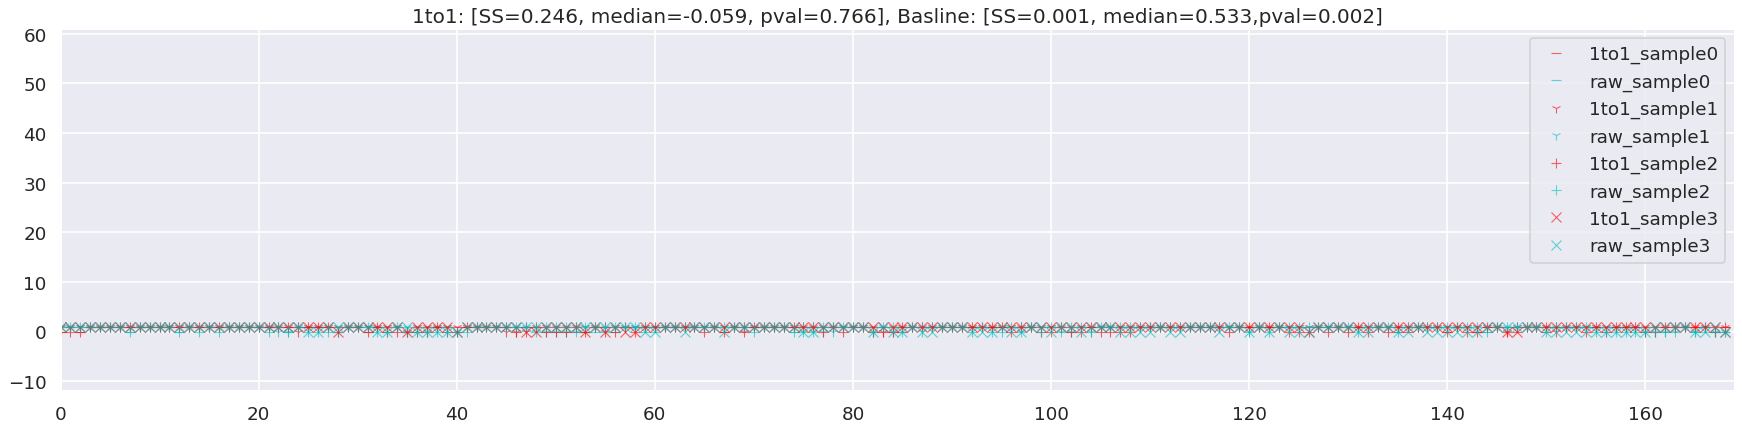

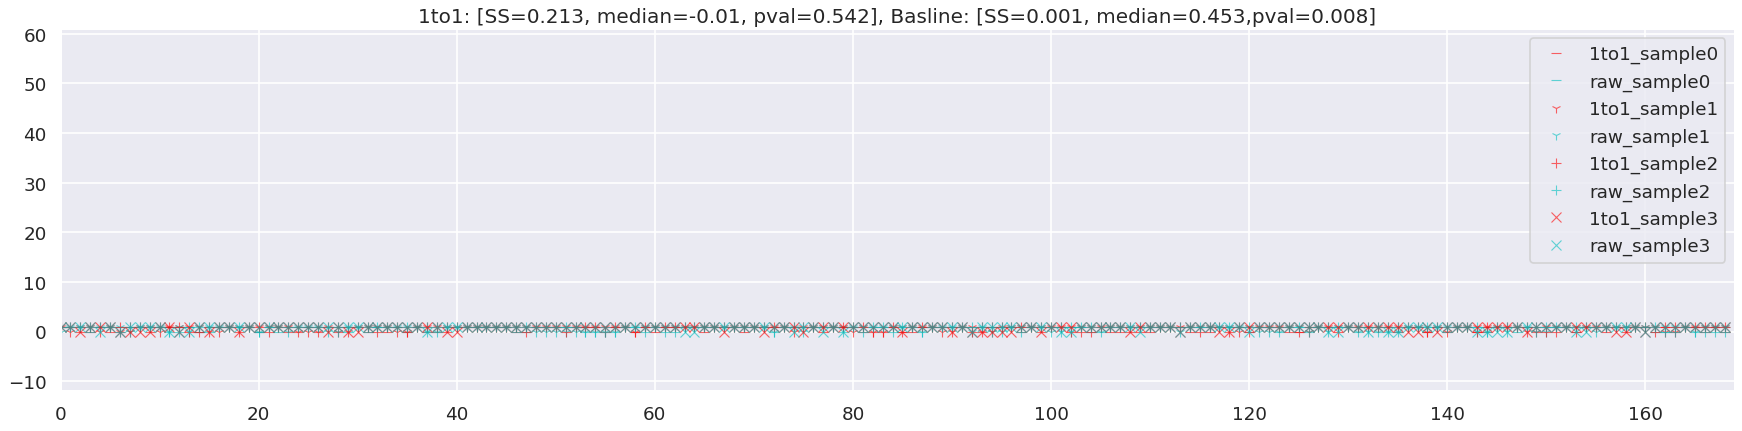

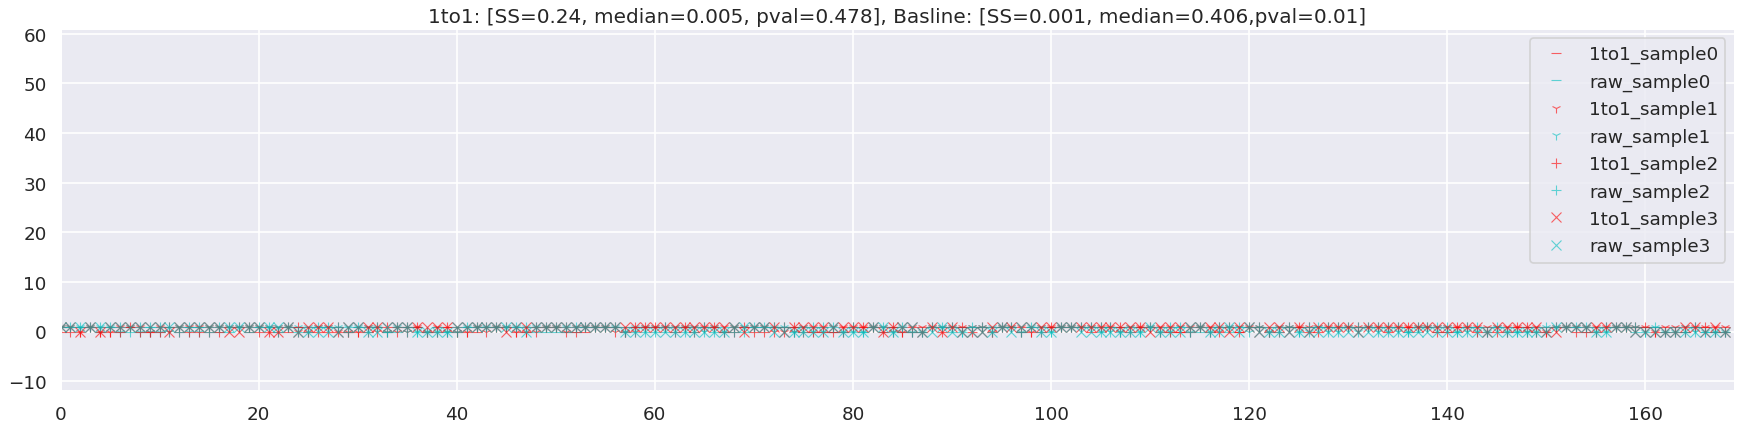

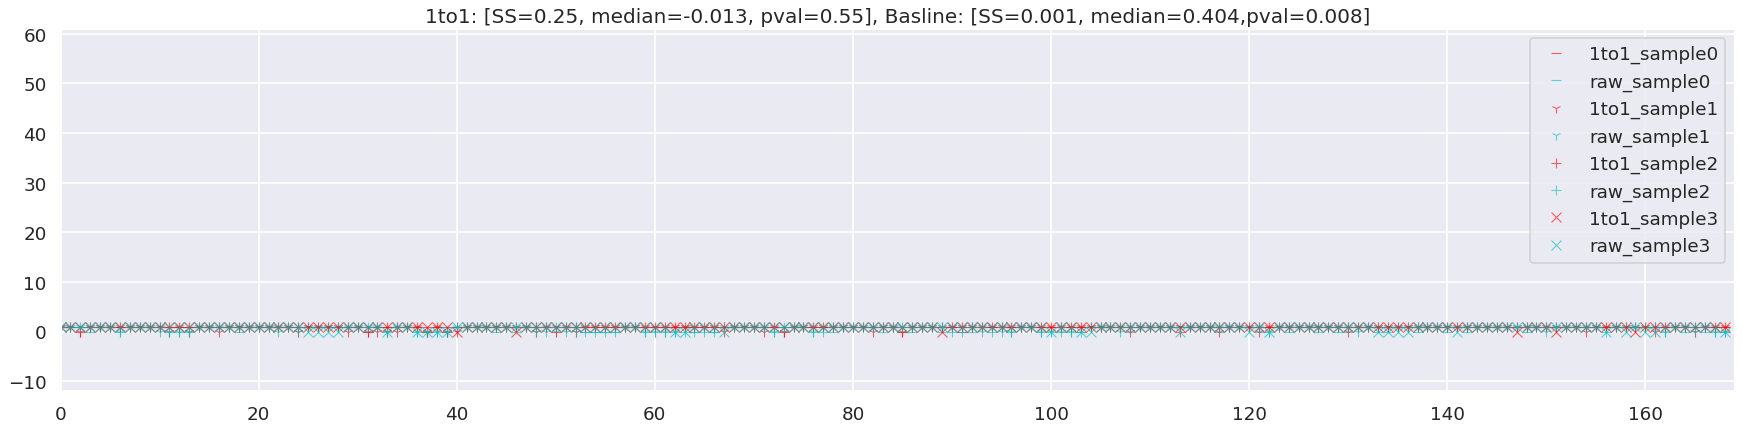

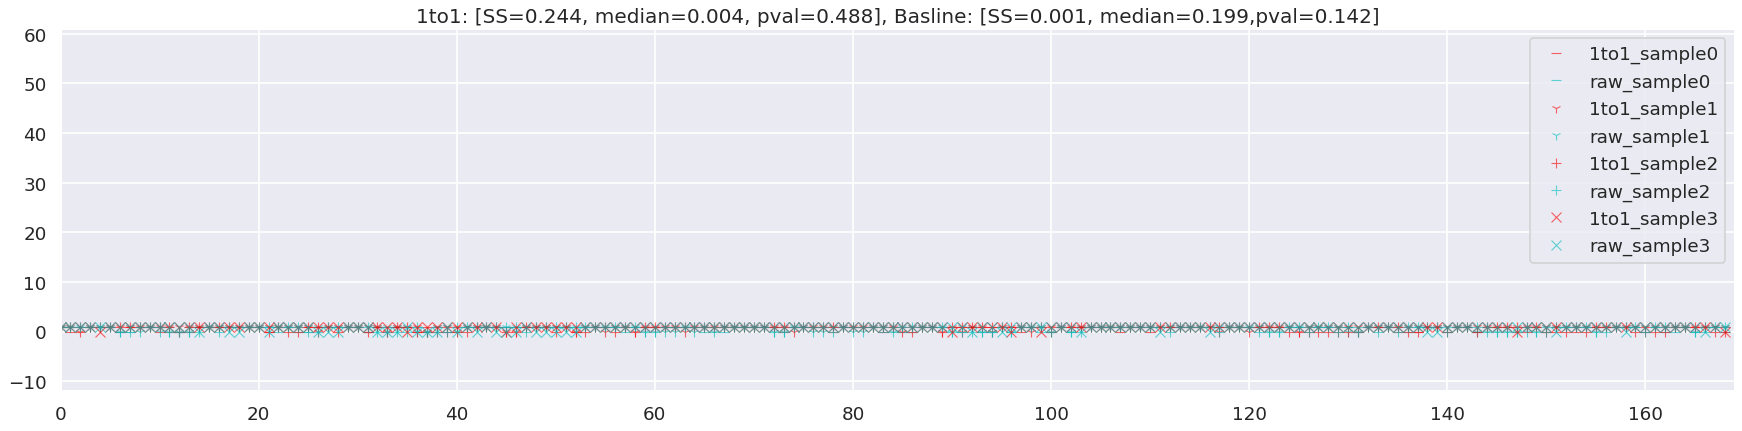

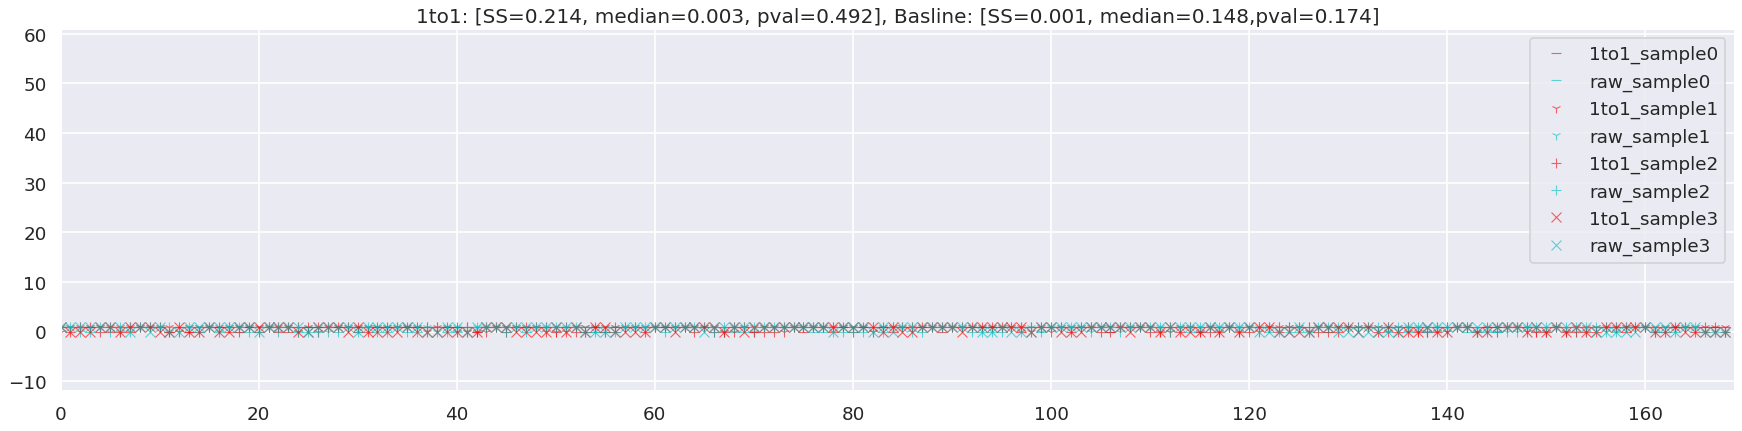

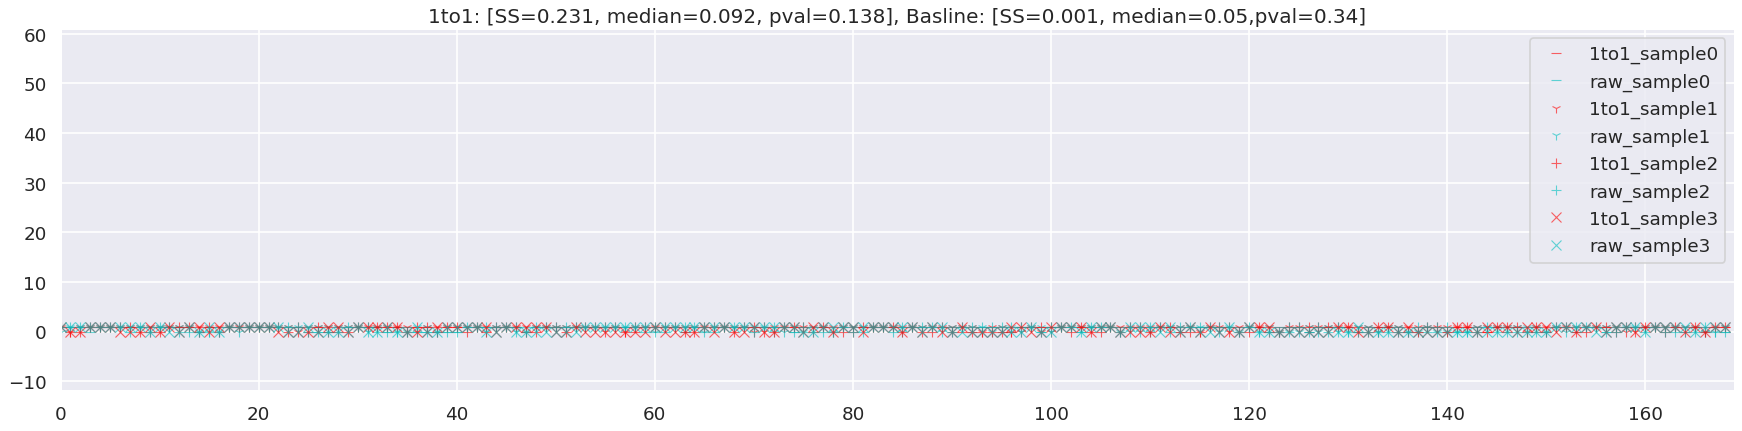

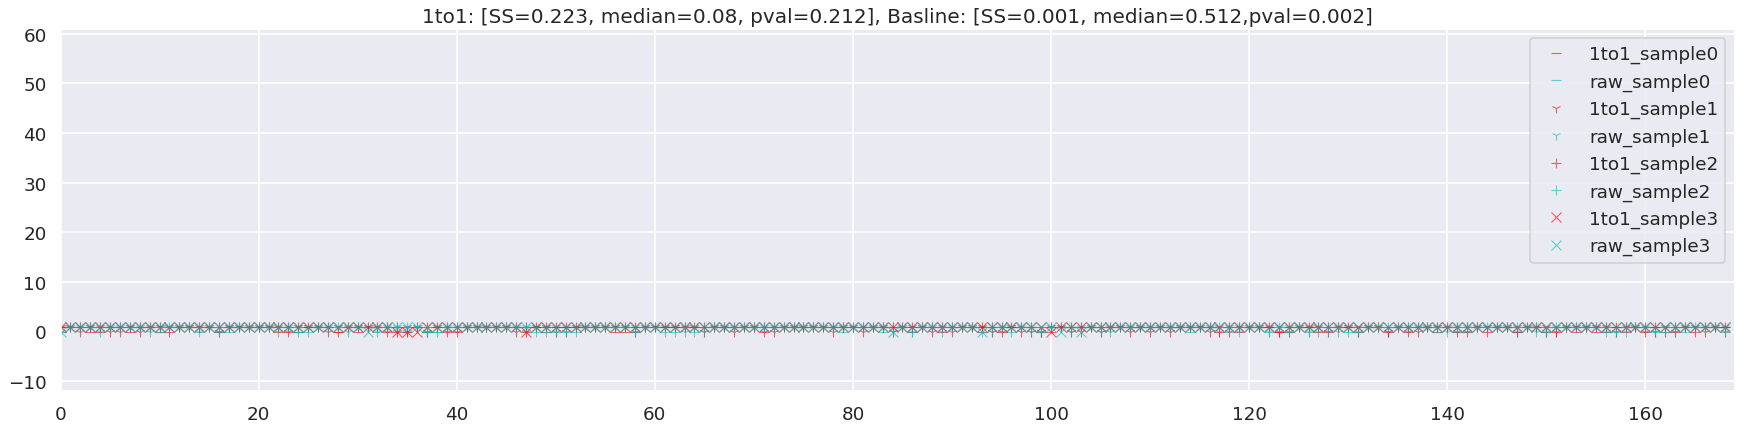

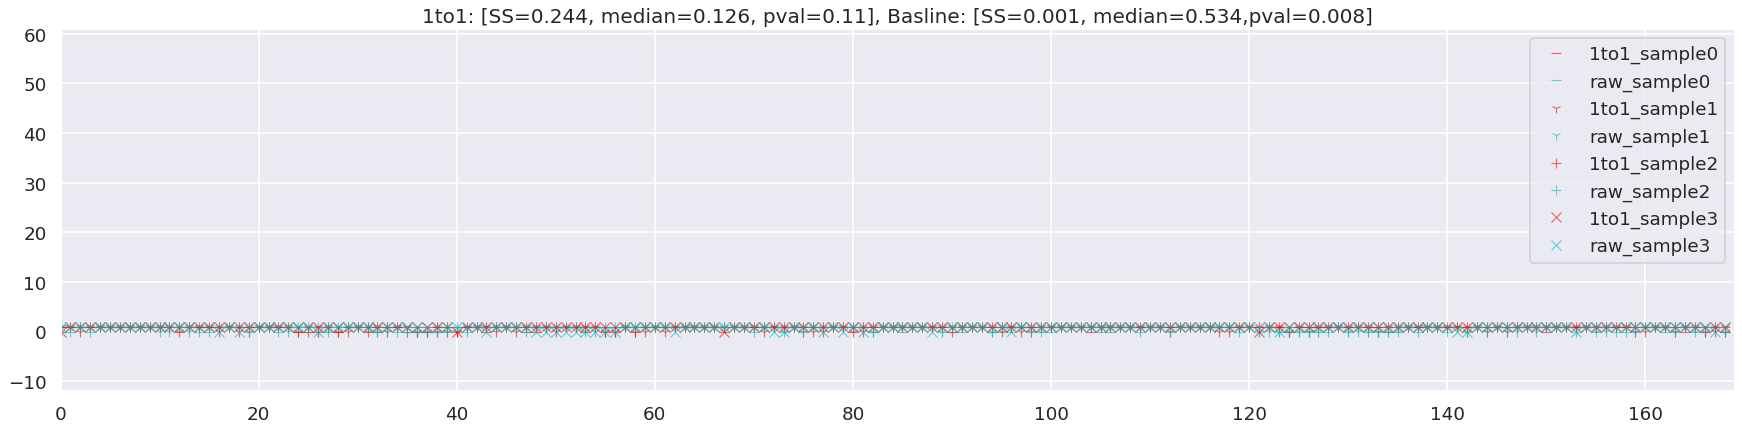

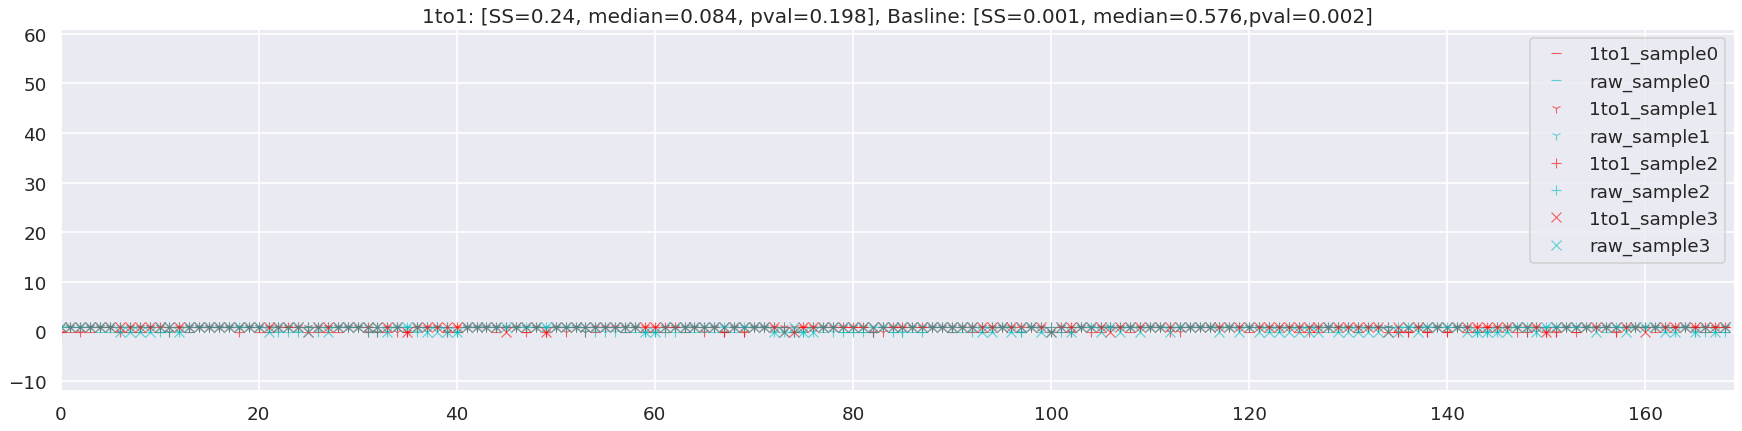

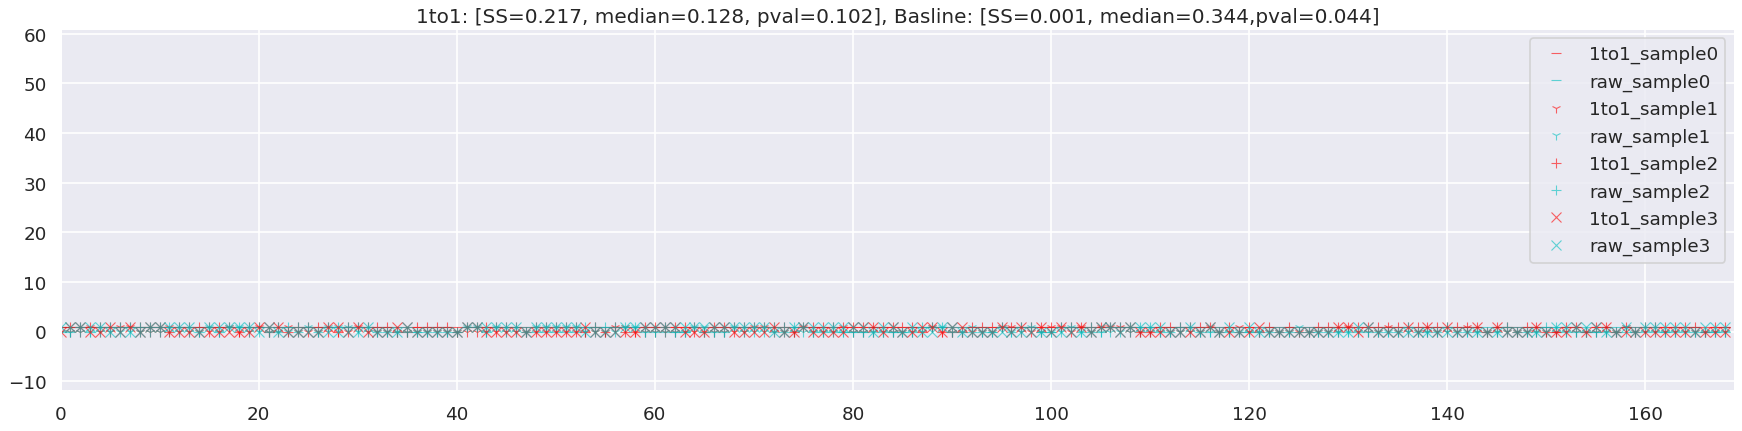

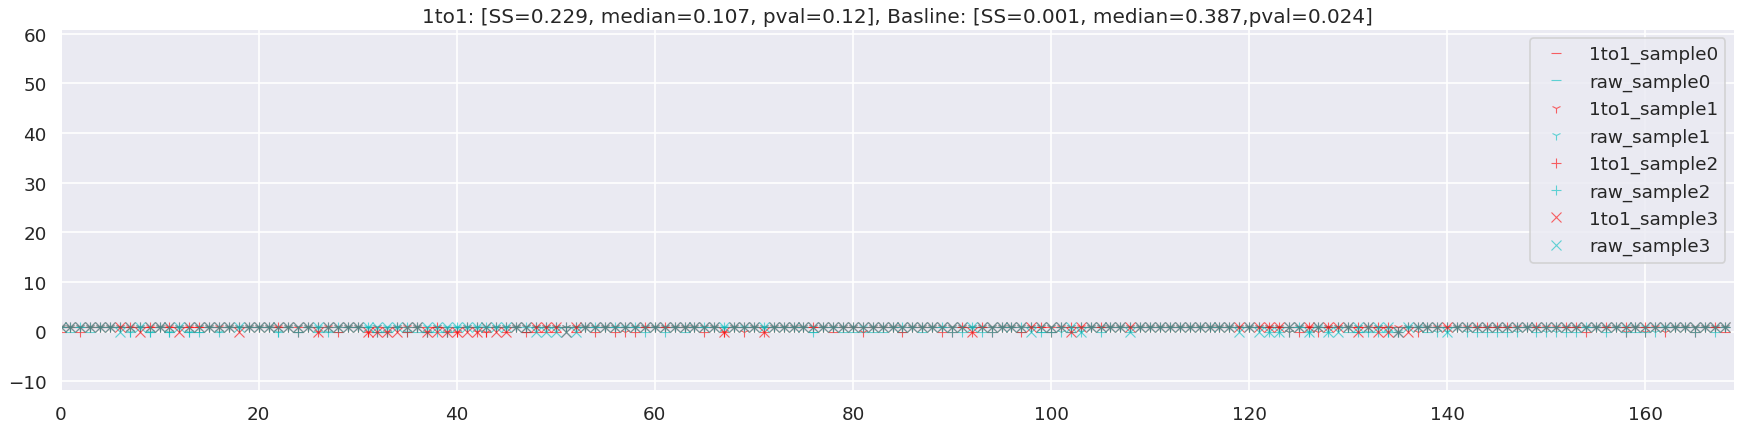

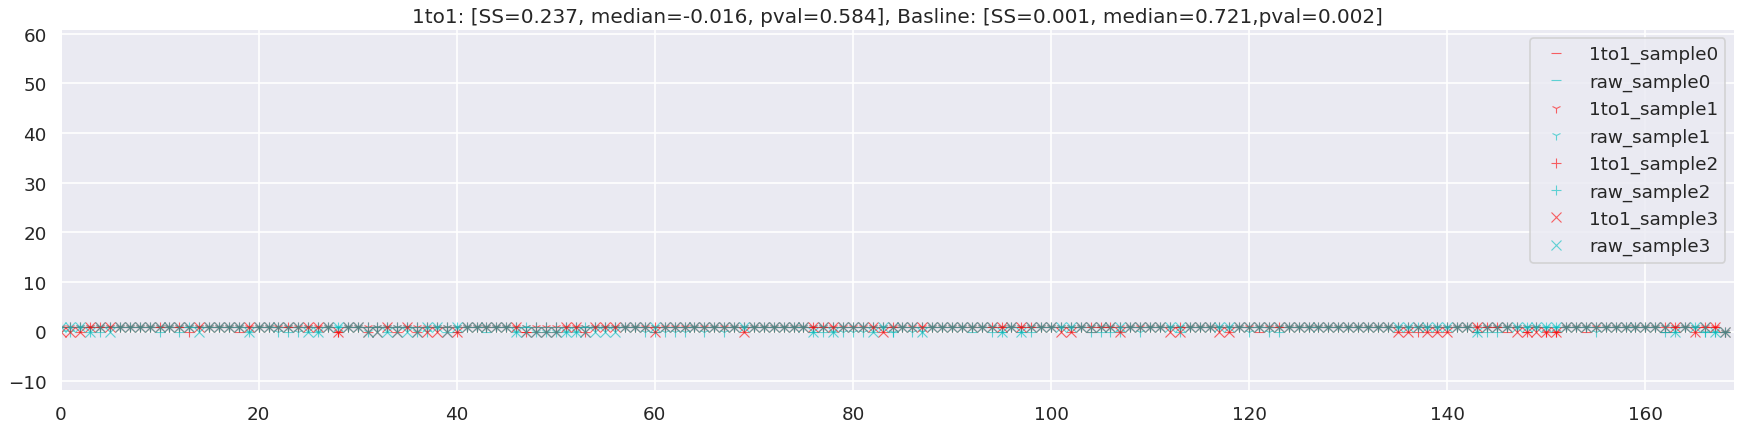

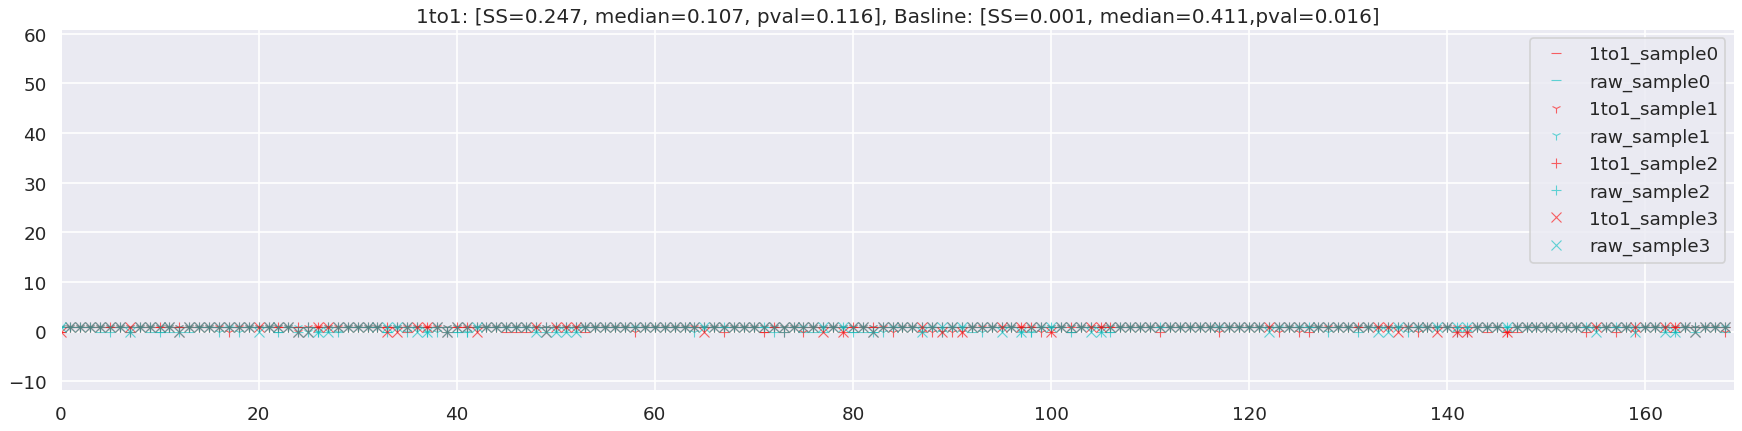

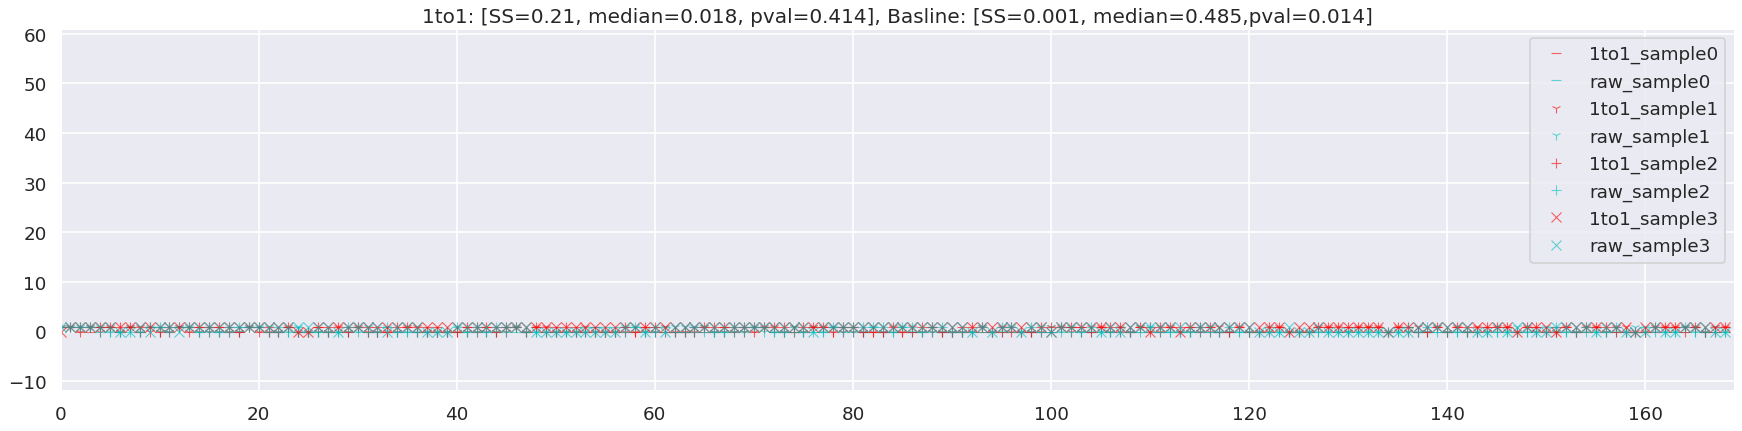

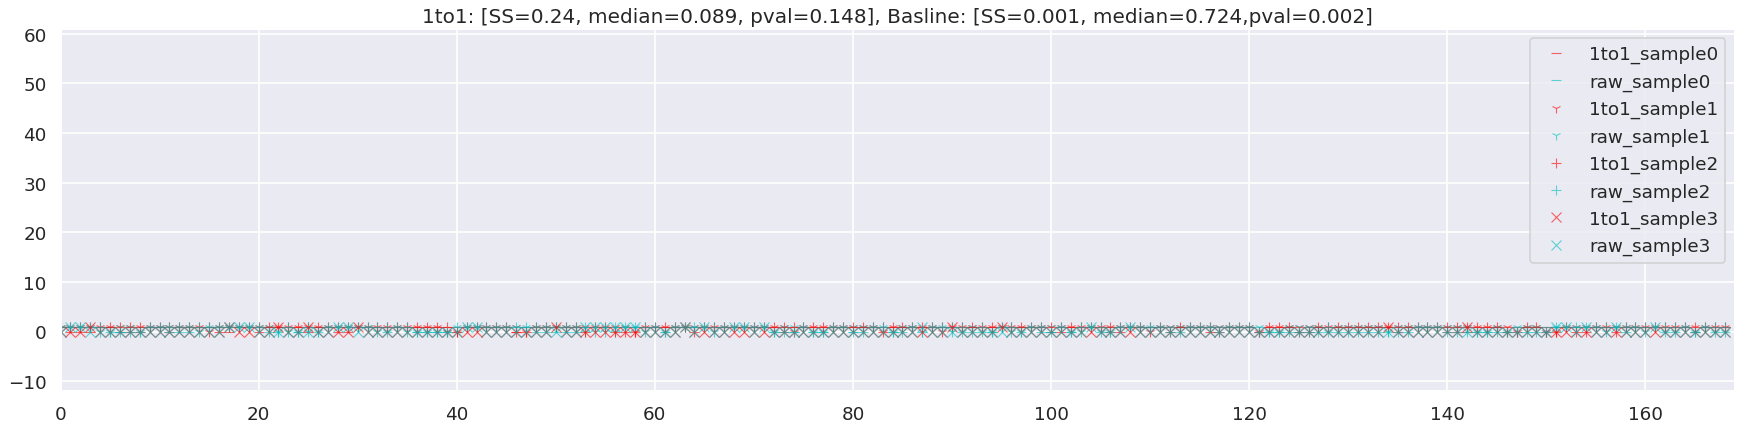

In [343]:
# zscores['raw']['trt'].loc[:,:,unreproduce_hits_idx.values[0],:].values.shape
# colors = ['r','b','g','c']


markers = ["_", "1","+","x"]

for u in range(len(unreproduce_hits_idx)):
    plt.figure(figsize=(27, 6), dpi=80)
    for i in range(len(colors)):
        y1 = zscores['1to1']['trt'].loc[:,:,unreproduce_hits_idx.values[u],:].values[i,:]
        y1[y1>60]=60
        y1[(60>y1) & (y1>50)]=50
        y1[(50>y1) & (y1>40)]=40
        y1[(40>y1) & (y1>30)]=30
        y1[(30>y1) & (y1>20)]=20
        y1_ss = melt_all[(melt_all['index']==unreproduce_hits_idx.values[u]) & (melt_all['method']=='1to1')]['SS'].values[0]
        y1_median = melt_all[(melt_all['index']==unreproduce_hits_idx.values[u]) & (melt_all['method']=='1to1')]['median_score'].values[0]
        y1_pval = melt_all[(melt_all['index']==unreproduce_hits_idx.values[u]) & (melt_all['method']=='1to1')]['pval'].values[0]
        
        y2 = zscores['raw']['trt'].loc[:,:,unreproduce_hits_idx.values[u],:].values[i,:]
        y2_ss = melt_all[(melt_all['index']==unreproduce_hits_idx.values[u]) & (melt_all['method']=='raw')]['SS'].values[0]
        y2_median = melt_all[(melt_all['index']==unreproduce_hits_idx.values[u]) & (melt_all['method']=='raw')]['median_score'].values[0]
        y2_pval = melt_all[(melt_all['index']==unreproduce_hits_idx.values[u]) & (melt_all['method']=='raw')]['pval'].values[0]
        
        x = range(len(y1))
        plt.plot(x, y1, color = 'r', linestyle='none', marker = markers[i],label=f"1to1_sample{i}",alpha=0.6)
        plt.plot(x, y2, color = 'c', linestyle='none' ,marker = markers[i], label =f"raw_sample{i}", alpha=0.6)
        plt.title(f'1to1: [SS={np.round(y1_ss,3)}, median={np.round(y1_median,3)}, pval={np.round(y1_pval,3)}], Basline: [SS={np.round(y2_ss,3)}, median={np.round(y2_median,3)},pval={np.round(y2_pval,3)}]')
        plt.legend(loc='upper right')
        plt.ylim([-12,61])
        plt.xlim([0,169])
        

In [344]:
melt_all[melt_all['index']==unreproduce_hits_idx.values[0]]

index method        SS  median_score   pval  pval_log
722    BRD-A39737108-003-05-5   1to1  0.242604      0.086913  0.158  0.801343
25655  BRD-A39737108-003-05-5    raw  0.001348      0.640933  0.002  2.698970

In [ ]:
z.filter(regex='AGP').agg(['mean', 'median','var'],axis=0)

In [ ]:
zscores['raw']['trt'].loc[:,:,unreproduce_hits_idx.values[0],:].filter(regex='AGP').agg(['mean', 'median','var','corr'],axis=0)

In [ ]:
ax = sns.kdeplot(data=percantage_replicating_df_non_melt, x='raw_log', y='1to1_log')
ax.plot([-0.5,3.5],[-0.5,3.5], 'r--')

In [ ]:
fig = plt.plot(percantage_replicating_df_non_melt['ALL_SS_2_1to1'], percantage_replicating_df_non_melt['1to1_log'], 'b.')
# plt.xlim([0.05,0.4])

In [ ]:
ax = sns.kdeplot(data=percantage_replicating_df_non_melt, x='ALL_SS_6_raw', y='raw_log')
ax.plot([0,1],[0,1], 'r--')

In [ ]:
percantage_replicating_df_non_melt.head()

In [ ]:
to1 = list(percantage_replicating_df_non_melt.filter(like='_1to1', axis=1).columns)
raw = list(percantage_replicating_df_non_melt.filter(like='_raw', axis=1).columns)

In [ ]:
percantage_replicating_df_non_melt[['Metadata_broad_sample']+to1].melt(id_vars=['Metadata_broad_sample'], value_vars=to1)

In [ ]:
percantage_replicating_df

In [ ]:
row_indices = percantage_replicating_df['p_val']<0.0001
percantage_replicating_df.loc[row_indices,'p_val']=0.0001
percantage_replicating_df['log10_p_val'] = - np.log10(percantage_replicating_df['p_val'])

plot_p_vs_median(percantage_replicating_df,'cellpainting_figures', 'p_vs_ss_log.png',x_col="SS")
# plot_p_vs_median(percantage_replicating_df,'cellpainting_figures', 'p_vs_fraction_log.png', x_col="fraction_score")
# plot_p_vs_median(percantage_replicating_df, 'cellpainting_figures', 'p_vs_median_log.png')
percantage_replicating_df.method.value_counts()

In [ ]:
def plot_score_distribution(df, title, path, file_name, x='p_val'):
    
    if not os.path.exists(path):
        os.mkdir(path)
        
    dis_plt = sns.displot(df, x=x, hue="method", kind="hist", 
                          multiple="stack", palette = 'viridis', height=6.5, aspect=1.7)
    dis_plt.fig.suptitle(title)
    dis_plt.fig.subplots_adjust(top=.92)
    plt.savefig(os.path.join(path, file_name))
    plt.show()
    

In [ ]:
x_col = 'p_val'
plot_score_distribution(
    percantage_replicating_df,
    f"{x_col} score distribution across methods",
    'cellpainting_figures',
    'p_value_distribution_all.png',
    x='p_val'
)

In [152]:
x_col = 'SS'
plot_score_distribution(
    percantage_replicating_df,
    f"{x_col} score distribution across methods",    
    'cellpainting_figures',
    'SS_score_distribution.png',
    x=x_col
)

ValueError: Could not interpret value `SS` for parameter `x`

In [153]:
x = 'p_val'
median_threshold = 20
plot_score_distribution(
    percantage_replicating_df[percantage_replicating_df['SS']>median_threshold],
    f'p_val distribution across methods for median corelation>{median_threshold}',
    'cellpainting_figures',
    f'{x} stacked distribution for median corelation larger than {median_threshold}.png',
    x=x
)

KeyError: 'SS'

In [154]:
x='SS'
p_val_threshold = 0.05
plot_score_distribution(
    percantage_replicating_df[percantage_replicating_df['p_val']<p_val_threshold],
    f'median scores distribution across methods for p_val<{p_val_threshold}',
    'cellpainting_figures',
    f'{x}_stacked_distribution for p_val smaller than {p_val_threshold}.png',
    x=x
)


ValueError: Could not interpret value `SS` for parameter `x`

In [155]:
x='SS'
p_val_threshold = 0.01
plot_score_distribution(
    percantage_replicating_df[percantage_replicating_df['p_val']<p_val_threshold],
    f'median scores distribution across methods for p_val<{p_val_threshold}',
    'cellpainting_figures',
    f'{x}_stacked_distribution for p_val smaller than {p_val_threshold}.png',
    x=x
)

ValueError: Could not interpret value `SS` for parameter `x`

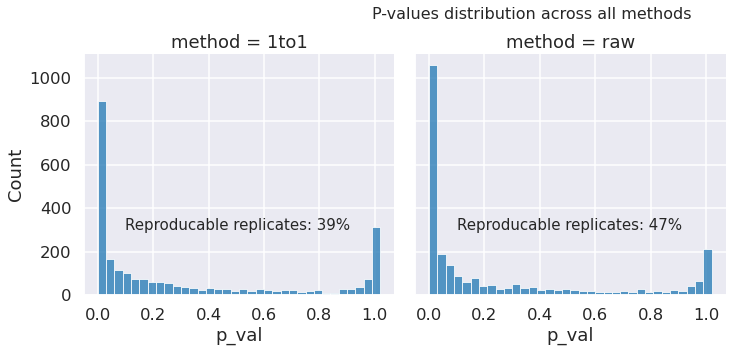

In [156]:
def plot_p_value_dist(df, path, file_name,thresh=0.05):
    """Plot p-values distribution"""
    if not os.path.exists(path):
        os.mkdir(path)  
    
    repr_score = {}
    methods = percantage_replicating_df.method.unique()
    for method in methods:
        df_method = percantage_replicating_df[percantage_replicating_df['method']==method]
        repr_score[method] = len(df_method[df_method['p_val']<=thresh])/ len(df_method)
    # repr_score
    dis_plt = sns.displot(df, x="p_val", col="method", col_wrap=3, binwidth=0.03)
    dis_plt.fig.suptitle("P-values distribution across all methods", size = 16)
    dis_plt.fig.subplots_adjust(top=.85)
    for ax, method in zip(dis_plt.axes.flat, methods):
        ax.text(0.1, 300,'Reproducable replicates: '+str(int(np.round(repr_score[method],2)*100))+'%', fontsize=15) #add text
    plt.savefig(os.path.join(path, file_name))
    plt.show()
    
plot_p_value_dist(percantage_replicating_df, 'cellpainting_figures', 'p_value_distribution_per_method.png',thresh=0.05)
repr_score = {}


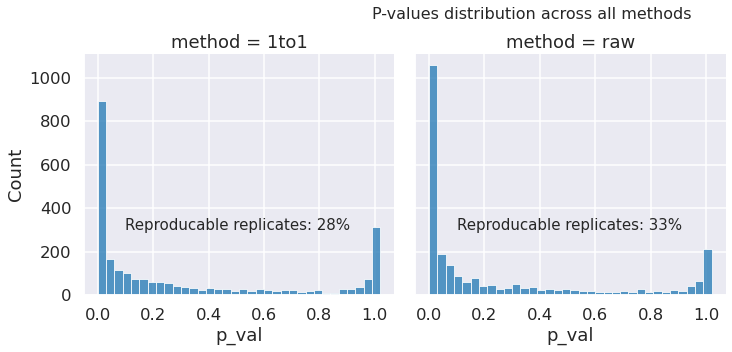

In [157]:
plot_p_value_dist(percantage_replicating_df, 'cellpainting_figures', 'p_value_distribution_per_method.png',thresh=0.01)
repr_score = {}

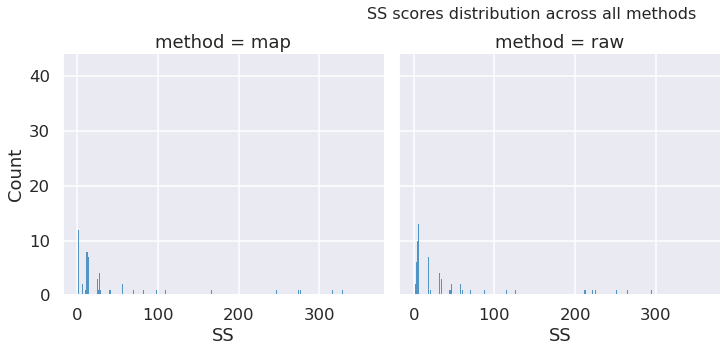

In [133]:
def plot_p_value_dist(df, path, file_name,x_col="fraction_score"):
    """Plot p-values distribution"""
    if not os.path.exists(path):
        os.mkdir(path)  
    dis_plt = sns.displot(df, x=x_col, col="method", col_wrap=3, binwidth=0.03)
    dis_plt.fig.suptitle(f"{x_col} scores distribution across all methods", size = 16)
    dis_plt.fig.subplots_adjust(top=.85)
    plt.savefig(os.path.join(path, file_name))
    plt.show()
                      
x_col="SS"
plot_p_value_dist(percantage_replicating_df, 'cellpainting_figures', f'{x_col}_score_distribution_per_method.png',x_col=x_col)

In [158]:
def plot_p_value_dist(df, path, file_name,x_col="fraction_score", kind="kde"):
    """Plot p-values distribution"""
    if not os.path.exists(path):
        os.mkdir(path)  
    if kind=="kde":
        dis_plt = sns.displot(df, x=x_col, hue="method", kind=kind)
    elif kind=="hist":
        dis_plt = sns.histplot(df, x=x_col, hue="method",element="step", fill=False)
        # , multiple="dodge")
    elif kind == "ecdf":
        dis_plt = sns.ecdfplot(df, x=x_col, hue="method",stat="count", complementary=True)
    # dis_plt = sns.displot(df, x=x_col, col="method", col_wrap=3, binwidth=0.03)
    plt.title(f"{x_col} scores distribution across all methods", size = 16)
    plt.tight_layout()
    # dis_plt.subplots_adjust(top=.85)
    plt.savefig(os.path.join(path, file_name))
    plt.show()
                      
x_col="SS"
plot_p_value_dist(percantage_replicating_df, 
                  'cellpainting_figures', 
                  f'{x_col}_score_distribution_per_method.png',
                 kind="hist")

# ax = sns.barplot(x="day", y="total_bill", hue="sex", data=tips)

ValueError: Could not interpret value `fraction_score` for parameter `x`

In [159]:
x='fraction_score'
p_val_threshold = 0.05
plot_p_value_dist(percantage_replicating_df[percantage_replicating_df['p_val']<p_val_threshold], 
                  'cellpainting_figures', 
                  f'{x_col}_score_distribution_per_method.png',
                 kind="hist")

ValueError: Could not interpret value `fraction_score` for parameter `x`

In [160]:
x='SS'

p_val_threshold = 0.01
plot_p_value_dist(percantage_replicating_df[percantage_replicating_df['p_val']<p_val_threshold], 
                  'cellpainting_figures', 
                  f'{x_col}_score_density for p_val smaller than {p_val_threshold}.png',
                 x_col=x)


p_val_threshold = 0.05
plot_p_value_dist(percantage_replicating_df[percantage_replicating_df['p_val']<p_val_threshold], 
                  'cellpainting_figures', 
                  f'{x_col}_score_density for p_val smaller than {p_val_threshold}.png',
                 x_col=x)

p_val_threshold = 1
plot_p_value_dist(percantage_replicating_df[percantage_replicating_df['p_val']<p_val_threshold], 
                  'cellpainting_figures', 
                  f'{x_col}_score_density for p_val smaller than {p_val_threshold}.png',
                 x_col=x)


ValueError: Could not interpret value `SS` for parameter `x`

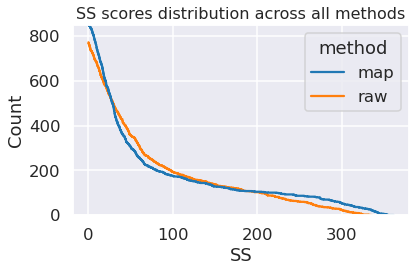

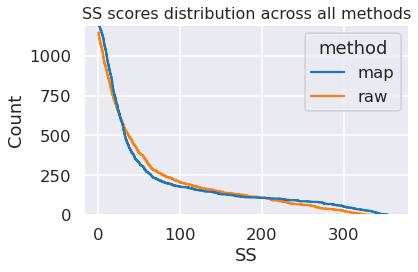

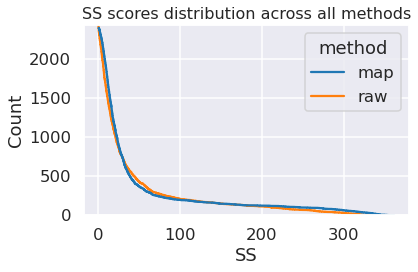

In [139]:
x='SS'

p_val_threshold = 0.01
plot_p_value_dist(percantage_replicating_df[percantage_replicating_df['p_val']<p_val_threshold], 
                  'cellpainting_figures', 
                  f'{x_col}_score ecdf for p_val smaller than {p_val_threshold}.png',
                 x_col=x
                  ,kind="ecdf")


p_val_threshold = 0.05
plot_p_value_dist(percantage_replicating_df[percantage_replicating_df['p_val']<p_val_threshold], 
                  'cellpainting_figures', 
                  f'{x_col}_score ecdf for p_val smaller than {p_val_threshold}.png',
                 x_col=x
                  ,kind="ecdf")

p_val_threshold = 1
plot_p_value_dist(percantage_replicating_df[percantage_replicating_df['p_val']<p_val_threshold], 
                  'cellpainting_figures', 
                  f'{x_col}_score ecdf for p_val smaller than {p_val_threshold}.png',
                 x_col=x
                  ,kind="ecdf")

In [205]:
# TODO
# 1. calc p-value for each cpd
# 2. plot graph
# 3. run for all plates
# 4. run on 1to1 and raw
# 4. add saving mechanisms
# 5. run for each scenario